In [1]:
import pandas

In [ ]:
# !pip install simpy

## 1. Base Case (D/M/1):
1. There is only a doctor as a server
2. The patients now strictly follow the schedule where each 15 mins, there would be a patient arriving at the clinic, waiting for the doctor and the previous patient to finish their consultation.
3. Service time follows an exponential distribution where it takes average 15 mins

### Techniques applied: 
1. np.random.exponential performs inverse CDF transform on exponential distribution and uses U = F(x)
2. Monte Carlo to get the expected value 
3. `L = expected num of customers in the system`
    - empirical 
    - from Little's Formula: `L = λW`
4. Variation Reduction Technique: Antithetic variable (`1-U`)


Running both regular and antithetic Monte Carlo simulations...
Running 1000 regular Monte Carlo simulations...

Simulation data saved to basic_case_dataframe.json
Running 1000 Monte Carlo simulations with antithetic variables...

Simulation data saved to antithetic_case_dataframe.json

VARIANCE REDUCTION ANALYSIS (Antithetic Variables)
Average Waiting Time Analysis:
  Regular MC Variance: 0.296877
  Antithetic MC Variance: 0.298226
  Variance Reduction: -0.45%

Little's Law L Analysis:
  Regular MC Variance: 3.019681
  Antithetic MC Variance: 3.010548
  Variance Reduction: 0.30%

Confidence Interval Comparison:
  Regular MC CI Width: ±0.0338 hours
  Antithetic MC CI Width: ±0.0239 hours
  CI Width Reduction: 29.13%

LITTLE'S LAW VALIDATION COMPARISON

REGULAR Monte Carlo:
  L from Little's Law (λW): 3.237585 customers
  L empirical (direct measurement): 3.287884 customers
  Average relative error: 3.3922%
  Paired t-test p-value: 0.000000
  Conclusion: Significant difference detected



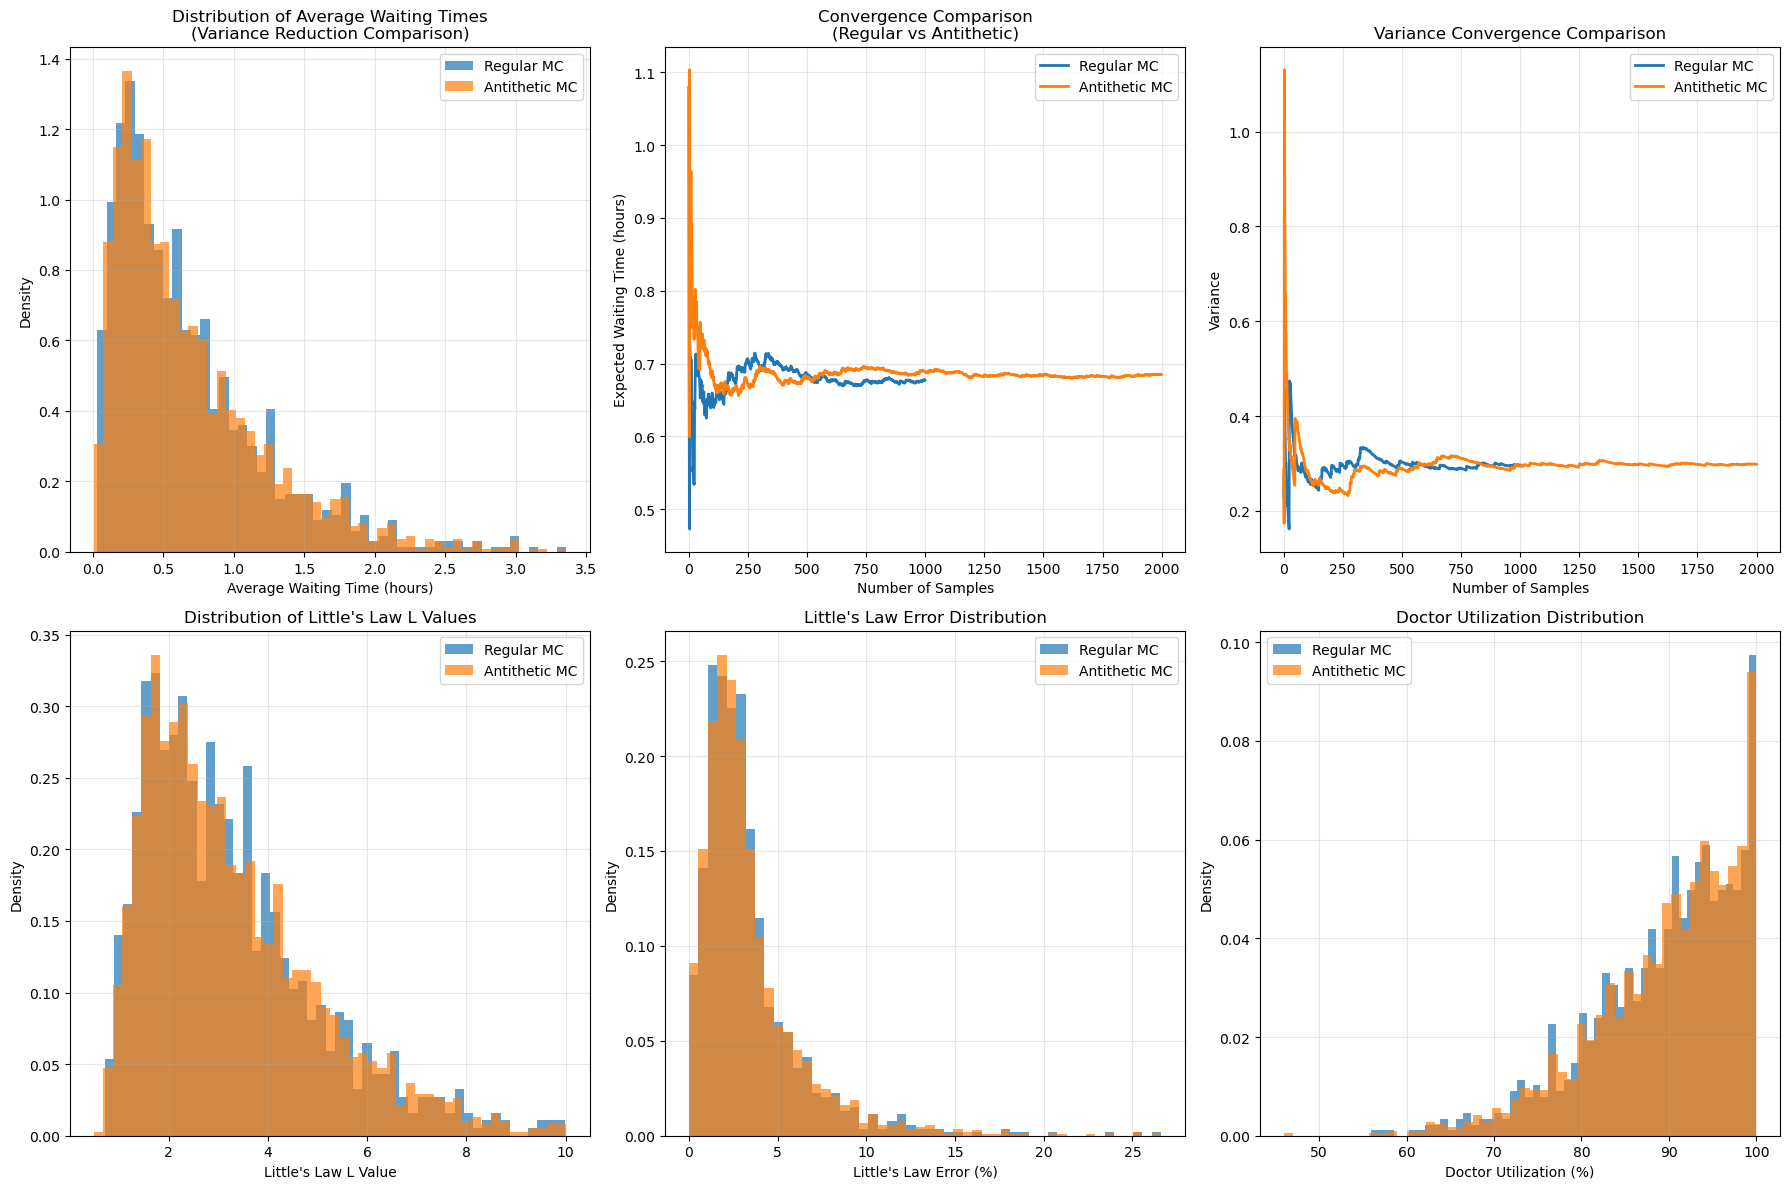


SAMPLE RESULTS SUMMARY (One Run with 40 Patients)

Patient Flow Details (Time in Hours):
 Customer_Sequence  Arrival_Time  Service_Start_Time  Service_End_Time  Waiting_Time
                 1          0.00            0.000000          0.117317      0.000000
                 2          0.25            0.250000          1.002530      0.000000
                 3          0.50            1.002530          1.331717      0.502530
                 4          0.75            1.331717          1.559952      0.581717
                 5          1.00            1.559952          1.602359      0.559952
                 6          1.25            1.602359          1.644758      0.352359
                 7          1.50            1.644758          1.659717      0.144758
                 8          1.75            1.750000          2.252808      0.000000
                 9          2.00            2.252808          2.482578      0.252808
                10          2.25            2.482578        

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

class ClinicQueueMonteCarlo:
    def __init__(self, clinic_hours=10, num_patients=40, mean_service_time=0.25, num_samples=1000):
        """
        Initialize the clinic queue Monte Carlo simulation
        
        Parameters:
        clinic_hours: Total clinic operating time in hours
        num_patients: Number of patients per day
        mean_service_time: Mean service time for exponential distribution (hours)
        num_samples: Number of Monte Carlo samples
        """
        self.clinic_hours = clinic_hours
        self.num_patients = num_patients
        self.mean_service_time = mean_service_time
        self.num_samples = num_samples
        self.inter_arrival_time = clinic_hours / num_patients  # 0.25 hours for 40 patients in 10 hours
        self.results = None
    
    def calculate_empirical_customers_in_system(self, df):
        """
        Calculate empirical average number of customers in system (L_empirical)
        by analyzing the system state over time
        """
        # Create time points for analysis (every minute)
        # 1 minute = 1/60 hours
        time_step = 1/60  # Convert 1 minute to hours
        time_points = np.arange(0, self.clinic_hours + time_step, time_step)
        customers_in_system = []
        
        for t in time_points:
            # Count customers who have arrived but not departed by time t
            arrived = df[df['Arrival_Time'] <= t]
            not_departed = arrived[arrived['Service_End_Time'] > t]
            num_in_system = len(not_departed)
            customers_in_system.append(num_in_system)
        
        # Calculate average number in system
        avg_customers_in_system = np.mean(customers_in_system)
        
        return {
            'time_points': time_points,
            'customers_in_system': customers_in_system,
            'avg_customers_in_system': avg_customers_in_system
        }
        
    def save_simulation_to_json(self, df, filename='basic_case_dataframe.json'):
        """Save simulation dataframe to JSON file"""
        # Convert DataFrame to JSON with proper formatting
        df.to_json(filename, orient='records', indent=2)
        print(f"\nSimulation data saved to {filename}")
    
    def simulate_single_run(self, service_times=None, seed=None):
        """Simulate a single day of clinic operations"""
        if seed is not None:
            np.random.seed(seed)
        
        # Initialize arrays
        customer_sequence = []
        arrival_times = []
        service_start_times = []
        service_times_list = []
        service_end_times = []
        waiting_times = []
        time_in_system = []
        
        # Generate service times if not provided
        if service_times is None:
            service_times = np.random.exponential(self.mean_service_time, self.num_patients)
        
        # Process each patient
        for i in range(self.num_patients):
            customer_sequence.append(i + 1)
            
            # Arrival time (fixed intervals)
            arrival_time = i * self.inter_arrival_time
            arrival_times.append(arrival_time)
            
            service_time = service_times[i]
            service_times_list.append(service_time)
            
            if i == 0:  # First patient
                service_start_time = arrival_time
                waiting_time = 0
            else:
                service_start_time = max(arrival_time, service_end_times[i-1])
                waiting_time = service_start_time - arrival_time
            
            service_start_times.append(service_start_time)
            waiting_times.append(waiting_time)
            
            service_end_time = service_start_time + service_time
            service_end_times.append(service_end_time)
            
            # Time in system (waiting + service)
            time_in_system.append(service_end_time - arrival_time)
        
        # Create DataFrame for this run
        df = pd.DataFrame({
            'Customer_Sequence': customer_sequence,
            'Arrival_Time': arrival_times,
            'Service_Start_Time': service_start_times,
            'Service_Time': service_times_list,
            'Service_End_Time': service_end_times,
            'Waiting_Time': waiting_times,
            'Time_in_System': time_in_system
        })
        
        return df
    
    def calculate_proper_littles_law(self, df, empirical_analysis=None):
        """Apply Little's Law correctly using system busy period"""
        
        # Use provided empirical analysis or calculate new one
        if empirical_analysis is None:
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
        
        # System starts empty at time 0
        start_time = 0
        
        # System ends when last patient departs
        end_time = df['Service_End_Time'].max()
        
        # Actual operating period for Little's Law
        operating_period = end_time - start_time
        
        # True arrival rate over the actual operating period
        true_λ = self.num_patients / operating_period
        
        # Average time in system
        W = df['Time_in_System'].mean()
        
        # Little's Law prediction
        L_little = true_λ * W
        
        # Empirical measurement over the same period
        mask = (empirical_analysis['time_points'] >= start_time) & (empirical_analysis['time_points'] <= end_time)
        L_empirical = np.mean(np.array(empirical_analysis['customers_in_system'])[mask])
        
        # Calculate difference and error
        difference = abs(L_little - L_empirical)
        relative_error = (difference / L_empirical) * 100 if L_empirical > 0 else 0
        
        result = {
            'arrival_rate': true_λ,
            'avg_time_in_system': W,
            'L_little': L_little,
            'L_empirical': L_empirical,
            'difference': difference,
            'relative_error_percent': relative_error,
            'operating_period': operating_period,
            'start_time': start_time,
            'end_time': end_time,
            'empirical_analysis': empirical_analysis
        }
        
        return result
    
    def monte_carlo_regular(self):
        """Run regular Monte Carlo simulation without variance reduction"""
        print(f"Running {self.num_samples} regular Monte Carlo simulations...")
        
        regular_results = []
        littles_law_results = []
        all_run_data = []  # Store all individual run data
        
        for i in range(self.num_samples):
            df = self.simulate_single_run(seed=i)
            
            # Store individual run data
            run_data = df.copy()
            run_data['run_id'] = i
            all_run_data.append(run_data)
            
            # Empirical analysis of customers in system
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
            
            # Little's Law analysis
            littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
            littles_law_results.append(littles_result)
            
            avg_waiting_time = df['Waiting_Time'].mean()
            max_waiting_time = df['Waiting_Time'].max()
            total_service_time = df['Service_Time'].sum()
            last_departure = df['Service_End_Time'].iloc[-1]
            
            regular_results.append({
                'sample': i,
                'type': 'regular',
                'avg_waiting_time': avg_waiting_time,
                'max_waiting_time': max_waiting_time,
                'total_service_time': total_service_time,
                'last_departure': last_departure,
                'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                'L_little': littles_result['L_little'],
                'L_empirical': littles_result['L_empirical'],
                'littles_error_percent': littles_result['relative_error_percent']
            })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'basic_case_dataframe.json')
        
        return pd.DataFrame(regular_results), pd.DataFrame(littles_law_results)
    
    def monte_carlo_antithetic(self):
        """Run Monte Carlo simulation with antithetic variables for variance reduction"""
        print(f"Running {self.num_samples} Monte Carlo simulations with antithetic variables...")
        
        antithetic_results = []
        littles_law_results = []
        all_run_data = []  # Store all individual run data
        
        for i in range(self.num_samples):
            # First run with seed i
            np.random.seed(i)
            u1 = np.random.random(self.num_patients)
            service_times1 = -self.mean_service_time * np.log(1 - u1)
            
            # Antithetic run using 1-u
            service_times2 = -self.mean_service_time * np.log(u1)
            
            # Run simulation with both service time sets
            for j, service_times in enumerate([service_times1, service_times2]):
                df = self.simulate_single_run(service_times=service_times)
                
                # Store individual run data
                run_data = df.copy()
                run_data['run_id'] = i * 2 + j
                run_data['pair_id'] = i
                all_run_data.append(run_data)
                
                # Empirical analysis of customers in system
                empirical_analysis = self.calculate_empirical_customers_in_system(df)
                
                # Little's Law analysis
                littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
                littles_law_results.append(littles_result)
                
                avg_waiting_time = df['Waiting_Time'].mean()
                max_waiting_time = df['Waiting_Time'].max()
                total_service_time = df['Service_Time'].sum()
                last_departure = df['Service_End_Time'].iloc[-1]
                
                antithetic_results.append({
                    'sample': i * 2 + j,
                    'type': 'antithetic',
                    'pair_id': i,
                    'avg_waiting_time': avg_waiting_time,
                    'max_waiting_time': max_waiting_time,
                    'total_service_time': total_service_time,
                    'last_departure': last_departure,
                    'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                    'L_little': littles_result['L_little'],
                    'L_empirical': littles_result['L_empirical'],
                    'littles_error_percent': littles_result['relative_error_percent']
                })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'antithetic_case_dataframe.json')
        
        return pd.DataFrame(antithetic_results), pd.DataFrame(littles_law_results)
    
    def run_both_methods(self):
        """Run both regular and antithetic Monte Carlo simulations"""
        print("Running both regular and antithetic Monte Carlo simulations...")
        
        # Regular Monte Carlo
        regular_df, regular_littles = self.monte_carlo_regular()
        
        # Antithetic Monte Carlo
        antithetic_df, antithetic_littles = self.monte_carlo_antithetic()
        
        self.results = {
            'regular': {
                'simulation': regular_df,
                'littles_law': regular_littles
            },
            'antithetic': {
                'simulation': antithetic_df,
                'littles_law': antithetic_littles
            }
        }
        
        return self.results
    
    def analyze_variance_reduction(self):
        """Analyze the effectiveness of antithetic variables for variance reduction"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        # Calculate statistics for waiting times
        regular_wait_var = regular_df['avg_waiting_time'].var()
        antithetic_wait_var = antithetic_df['avg_waiting_time'].var()
        
        # Calculate statistics for Little's Law L values
        regular_L_var = regular_df['L_little'].var()
        antithetic_L_var = antithetic_df['L_little'].var()
        
        # Variance reduction percentages
        wait_variance_reduction = (regular_wait_var - antithetic_wait_var) / regular_wait_var * 100
        L_variance_reduction = (regular_L_var - antithetic_L_var) / regular_L_var * 100
        
        print("\n" + "="*80)
        print("VARIANCE REDUCTION ANALYSIS (Antithetic Variables)")
        print("="*80)
        print(f"Average Waiting Time Analysis:")
        print(f"  Regular MC Variance: {regular_wait_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_wait_var:.6f}")
        print(f"  Variance Reduction: {wait_variance_reduction:.2f}%")
        
        print(f"\nLittle's Law L Analysis:")
        print(f"  Regular MC Variance: {regular_L_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_L_var:.6f}")
        print(f"  Variance Reduction: {L_variance_reduction:.2f}%")
        
        print(f"\nConfidence Interval Comparison:")
        regular_ci_width = 1.96 * np.sqrt(regular_wait_var / len(regular_df))
        antithetic_ci_width = 1.96 * np.sqrt(antithetic_wait_var / len(antithetic_df))
        print(f"  Regular MC CI Width: ±{regular_ci_width:.4f} hours")
        print(f"  Antithetic MC CI Width: ±{antithetic_ci_width:.4f} hours")
        print(f"  CI Width Reduction: {((regular_ci_width - antithetic_ci_width) / regular_ci_width * 100):.2f}%")
        
        return {
            'wait_variance_reduction': wait_variance_reduction,
            'L_variance_reduction': L_variance_reduction,
            'regular_stats': regular_df.describe(),
            'antithetic_stats': antithetic_df.describe()
        }
    
    def analyze_littles_law_validation(self):
        """Analyze Little's Law validation across both methods"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        # Little's Law validation statistics
        methods = ['regular', 'antithetic']
        results = {}
        
        for method in methods:
            df = self.results[method]['simulation']
            avg_L_little = df['L_little'].mean()
            avg_L_empirical = df['L_empirical'].mean()
            avg_error = df['littles_error_percent'].mean()
            
            # Statistical test for difference
            t_stat, p_value = stats.ttest_rel(df['L_little'], df['L_empirical'])
            
            results[method] = {
                'avg_L_little': avg_L_little,
                'avg_L_empirical': avg_L_empirical,
                'avg_error_percent': avg_error,
                'p_value': p_value
            }
        
        print("\n" + "="*80)
        print("LITTLE'S LAW VALIDATION COMPARISON")
        print("="*80)
        
        for method in methods:
            result = results[method]
            print(f"\n{method.upper()} Monte Carlo:")
            print(f"  L from Little's Law (λW): {result['avg_L_little']:.6f} customers")
            print(f"  L empirical (direct measurement): {result['avg_L_empirical']:.6f} customers")
            print(f"  Average relative error: {result['avg_error_percent']:.4f}%")
            print(f"  Paired t-test p-value: {result['p_value']:.6f}")
            if result['p_value'] > 0.05:
                print("  Conclusion: No significant difference (Little's Law holds)")
            else:
                print("  Conclusion: Significant difference detected")
        
        return results
    
    def plot_comparison(self):
        """Plot comparison between regular and antithetic methods"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of average waiting times
        axes[0, 0].hist(regular_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[0, 0].hist(antithetic_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[0, 0].set_xlabel('Average Waiting Time (hours)')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Distribution of Average Waiting Times\n(Variance Reduction Comparison)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Convergence of expected waiting time
        regular_cumulative = regular_df['avg_waiting_time'].expanding().mean()
        antithetic_cumulative = antithetic_df['avg_waiting_time'].expanding().mean()
        
        axes[0, 1].plot(regular_cumulative.index, regular_cumulative.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 1].plot(antithetic_cumulative.index, antithetic_cumulative.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 1].set_xlabel('Number of Samples')
        axes[0, 1].set_ylabel('Expected Waiting Time (hours)')
        axes[0, 1].set_title('Convergence Comparison\n(Regular vs Antithetic)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Variance comparison
        regular_variance = regular_df['avg_waiting_time'].expanding().var()
        antithetic_variance = antithetic_df['avg_waiting_time'].expanding().var()
        
        axes[0, 2].plot(regular_variance.index, regular_variance.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 2].plot(antithetic_variance.index, antithetic_variance.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 2].set_xlabel('Number of Samples')
        axes[0, 2].set_ylabel('Variance')
        axes[0, 2].set_title('Variance Convergence Comparison')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Little's Law L values distribution
        axes[1, 0].hist(regular_df['L_little'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 0].hist(antithetic_df['L_little'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 0].set_xlabel('Little\'s Law L Value')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Distribution of Little\'s Law L Values')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Error distribution comparison
        axes[1, 1].hist(regular_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 1].hist(antithetic_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 1].set_xlabel('Little\'s Law Error (%)')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Little\'s Law Error Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Doctor utilization comparison
        axes[1, 2].hist(regular_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 2].hist(antithetic_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 2].set_xlabel('Doctor Utilization (%)')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].set_title('Doctor Utilization Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize simulation
    mc_clinic = ClinicQueueMonteCarlo(
        clinic_hours=10,         # 10 hours
        num_patients=40,         # 40 patients
        mean_service_time=0.25,  # 0.25 hours (15 minutes) average service time
        num_samples=1000         # 1000 Monte Carlo samples
    )
    
    # Run both regular and antithetic Monte Carlo simulations
    results = mc_clinic.run_both_methods()
    
    # Analyze variance reduction
    variance_analysis = mc_clinic.analyze_variance_reduction()
    
    # Analyze Little's Law validation
    littles_analysis = mc_clinic.analyze_littles_law_validation()
    
    # Plot comprehensive comparison
    mc_clinic.plot_comparison()
    
    # Show sample results
    print("\n" + "="*80)
    print("SAMPLE RESULTS SUMMARY (One Run with 40 Patients)")
    print("="*80)
    
    sample_regular = mc_clinic.simulate_single_run(seed=42)
    empirical_analysis = mc_clinic.calculate_empirical_customers_in_system(sample_regular)
    littles_result = mc_clinic.calculate_proper_littles_law(sample_regular, empirical_analysis)
    
    print("\nPatient Flow Details (Time in Hours):")
    print(sample_regular[['Customer_Sequence', 'Arrival_Time', 'Service_Start_Time', 
                          'Service_End_Time', 'Waiting_Time']].to_string(index=False))
    
    print(f"\n\nSummary Statistics:")
    print(f"  Average Waiting Time: {sample_regular['Waiting_Time'].mean():.4f} hours")
    print(f"  Maximum Waiting Time: {sample_regular['Waiting_Time'].max():.4f} hours")
    print(f"  Average Time in System: {sample_regular['Time_in_System'].mean():.4f} hours")
    print(f"  Total Service Time: {sample_regular['Service_Time'].sum():.4f} hours")
    print(f"  Last Patient Departure: {sample_regular['Service_End_Time'].iloc[-1]:.4f} hours")
    print(f"  Doctor Utilization: {(sample_regular['Service_Time'].sum() / sample_regular['Service_End_Time'].iloc[-1] * 100):.2f}%")

### Loading a sample from json file 

In [6]:
import pandas as pd
import json

def load_single_simulation_run(filename='basic_case_dataframe_D_M_1.json', run_id=0):
    """
    Load a single simulation run from the JSON file
    
    Parameters:
    -----------
    filename : str
        Path to the JSON file
    run_id : int
        The run_id to extract (0-999)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing only the specified run
    """
    # Load the JSON file
    df = pd.read_json(filename, orient='records')
    
    # Filter for the specific run
    single_run = df[df['run_id'] == run_id].copy()
    
    # Reset index for cleaner display
    single_run.reset_index(drop=True, inplace=True)
    
    return single_run

### Inspecting D/M/1 (Regular Monte Carlo) 

In [7]:
run_number = 0

single_run_basic_D_df = load_single_simulation_run(
    filename='basic_case_dataframe_D_M_1.json',
    run_id=run_number
)

print(f"\n{'='*60}")
print(f"Simulation Run #{run_number}")
print(f"{'='*60}")
print(f"\nNumber of customers in this run: {len(single_run_basic_D_df)}")
print(f"\n{single_run_basic_D_df}")

# Display summary statistics
print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"{'='*60}")
print(single_run_basic_D_df.describe())


Simulation Run #0

Number of customers in this run: 40

    Customer_Sequence  Arrival_Time  Service_Start_Time  Service_Time  \
0                   1          0.00            0.000000      0.198969   
1                   2          0.25            0.250000      0.313983   
2                   3          0.50            0.563983      0.230806   
3                   4          0.75            0.794788      0.196800   
4                   5          1.00            1.000000      0.137762   
5                   6          1.25            1.250000      0.259540   
6                   7          1.50            1.509540      0.143880   
7                   8          1.75            1.750000      0.555881   
8                   9          2.00            2.305881      0.828728   
9                  10          2.25            3.134609      0.120901   
10                 11          2.50            3.255510      0.392224   
11                 12          2.75            3.647734      0.1881

### Inspecting D/M/1 (Antithetic Monte Carlo)

In [8]:
run_number = 0

single_run_antithetic_D_df = load_single_simulation_run(
    filename='antithetic_case_dataframe_D_M_1.json',
    run_id=run_number
)

print(f"\n{'='*60}")
print(f"Simulation Run #{run_number}")
print(f"{'='*60}")
print(f"\nNumber of customers in this run: {len(single_run_antithetic_D_df)}")
print(f"\n{single_run_antithetic_D_df}")

# Display summary statistics
print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"{'='*60}")
print(single_run_antithetic_D_df.describe())


Simulation Run #0

Number of customers in this run: 40

    Customer_Sequence  Arrival_Time  Service_Start_Time  Service_Time  \
0                   1          0.00            0.000000      0.198969   
1                   2          0.25            0.250000      0.313983   
2                   3          0.50            0.563983      0.230806   
3                   4          0.75            0.794788      0.196800   
4                   5          1.00            1.000000      0.137762   
5                   6          1.25            1.250000      0.259540   
6                   7          1.50            1.509540      0.143880   
7                   8          1.75            1.750000      0.555881   
8                   9          2.00            2.305881      0.828728   
9                  10          2.25            3.134609      0.120901   
10                 11          2.50            3.255510      0.392224   
11                 12          2.75            3.647734      0.1881

In [9]:
import pandas as pd
import numpy as np
from scipy import stats
import json

class VarianceReductionAnalyzer:
    def __init__(self, regular_file='basic_case_dataframe_D_M_1.json', 
                 antithetic_file='antithetic_case_dataframe_D_M_1.json'):
        """Initialize analyzer with file paths"""
        self.regular_file = regular_file
        self.antithetic_file = antithetic_file
        self.regular_data = None
        self.antithetic_data = None
        self.regular_summary = None
        self.antithetic_summary = None
        
    def load_data(self):
        """Load both JSON files"""
        print("Loading data files...")
        self.regular_data = pd.read_json(self.regular_file, orient='records')
        self.antithetic_data = pd.read_json(self.antithetic_file, orient='records')
        print(f"Regular data: {len(self.regular_data)} rows, {self.regular_data['run_id'].nunique()} runs")
        print(f"Antithetic data: {len(self.antithetic_data)} rows, {self.antithetic_data['run_id'].nunique()} runs")
        
    def calculate_per_run_statistics(self):
        """Calculate statistics for each run"""
        print("\nCalculating per-run statistics...")
        
        # Regular Monte Carlo
        self.regular_summary = self.regular_data.groupby('run_id').agg({
            'Waiting_Time': ['mean', 'std', 'max', 'min'],
            'Service_Time': ['sum', 'mean'],
            'Service_End_Time': 'max'
        }).reset_index()
        
        # Flatten column names
        self.regular_summary.columns = ['run_id', 'avg_waiting_time', 'std_waiting_time', 
                                        'max_waiting_time', 'min_waiting_time',
                                        'total_service_time', 'avg_service_time', 
                                        'last_departure']
        
        # Antithetic Variables
        self.antithetic_summary = self.antithetic_data.groupby('run_id').agg({
            'Waiting_Time': ['mean', 'std', 'max', 'min'],
            'Service_Time': ['sum', 'mean'],
            'Service_End_Time': 'max'
        }).reset_index()
        
        # Flatten column names
        self.antithetic_summary.columns = ['run_id', 'avg_waiting_time', 'std_waiting_time',
                                           'max_waiting_time', 'min_waiting_time',
                                           'total_service_time', 'avg_service_time',
                                           'last_departure']
        
    def analyze_variance_reduction(self):
        """Analyze variance reduction from antithetic variables"""
        print("\n" + "="*80)
        print("VARIANCE REDUCTION ANALYSIS")
        print("="*80)
        
        # Calculate variances
        regular_var = self.regular_summary['avg_waiting_time'].var()
        antithetic_var = self.antithetic_summary['avg_waiting_time'].var()
        
        # Variance reduction
        variance_reduction = ((regular_var - antithetic_var) / regular_var) * 100
        
        # Standard deviations
        regular_std = self.regular_summary['avg_waiting_time'].std()
        antithetic_std = self.antithetic_summary['avg_waiting_time'].std()
        
        # Means
        regular_mean = self.regular_summary['avg_waiting_time'].mean()
        antithetic_mean = self.antithetic_summary['avg_waiting_time'].mean()
        
        # Coefficient of variation
        regular_cv = (regular_std / regular_mean) * 100
        antithetic_cv = (antithetic_std / antithetic_mean) * 100
        
        print("\nWAITING TIME STATISTICS (Average per Run):")
        print("-" * 80)
        print(f"{'Metric':<30} {'Regular MC':<20} {'Antithetic MC':<20}")
        print("-" * 80)
        print(f"{'Mean:':<30} {regular_mean:<20.6f} {antithetic_mean:<20.6f}")
        print(f"{'Variance:':<30} {regular_var:<20.6f} {antithetic_var:<20.6f}")
        print(f"{'Std Deviation:':<30} {regular_std:<20.6f} {antithetic_std:<20.6f}")
        print(f"{'Coefficient of Variation:':<30} {regular_cv:<20.4f}% {antithetic_cv:<20.4f}%")
        print("-" * 80)
        print(f"{'VARIANCE REDUCTION:':<30} {variance_reduction:<20.4f}%")
        print("-" * 80)
        
        # Confidence intervals
        regular_ci = stats.t.interval(0.95, len(self.regular_summary)-1,
                                      loc=regular_mean,
                                      scale=stats.sem(self.regular_summary['avg_waiting_time']))
        antithetic_ci = stats.t.interval(0.95, len(self.antithetic_summary)-1,
                                        loc=antithetic_mean,
                                        scale=stats.sem(self.antithetic_summary['avg_waiting_time']))
        
        print(f"\n95% Confidence Intervals:")
        print(f"  Regular MC:    [{regular_ci[0]:.6f}, {regular_ci[1]:.6f}]")
        print(f"  Antithetic MC: [{antithetic_ci[0]:.6f}, {antithetic_ci[1]:.6f}]")
        print(f"  CI Width Reduction: {((regular_ci[1]-regular_ci[0]) - (antithetic_ci[1]-antithetic_ci[0])) / (regular_ci[1]-regular_ci[0]) * 100:.2f}%")
        
        # Statistical test
        t_stat, p_value = stats.ttest_ind(self.regular_summary['avg_waiting_time'],
                                          self.antithetic_summary['avg_waiting_time'])
        print(f"\nTwo-sample t-test:")
        print(f"  t-statistic: {t_stat:.6f}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Means are {'significantly different' if p_value < 0.05 else 'not significantly different'} at α=0.05")
        
        return {
            'regular_var': regular_var,
            'antithetic_var': antithetic_var,
            'variance_reduction_percent': variance_reduction,
            'regular_mean': regular_mean,
            'antithetic_mean': antithetic_mean
        }
    
    def calculate_littles_law_metrics(self, df, run_id):
        """Calculate Little's Law metrics for a single run"""
        run_data = df[df['run_id'] == run_id].copy()
        
        if len(run_data) == 0:
            return None
        
        # Sort by arrival time
        run_data = run_data.sort_values('Arrival_Time').reset_index(drop=True)
        
        # Calculate metrics
        total_customers = len(run_data)
        last_departure = run_data['Service_End_Time'].max()
        avg_waiting_time = run_data['Waiting_Time'].mean()
        avg_service_time = run_data['Service_Time'].mean()
        
        # Arrival rate
        if last_departure > 0:
            arrival_rate = total_customers / last_departure
        else:
            arrival_rate = 0
        
        # Little's Law: L = λW (where W is total time in system)
        avg_time_in_system = avg_waiting_time + avg_service_time
        L_little = arrival_rate * avg_time_in_system
        
        # Empirical L (average customers in system)
        # Calculate area under the curve
        total_area = 0
        for i in range(len(run_data)):
            if i == 0:
                continue
            
            # Time from previous departure to current arrival
            prev_departure = run_data.loc[i-1, 'Service_End_Time']
            curr_arrival = run_data.loc[i, 'Arrival_Time']
            
            # Count customers in system during this interval
            customers_in_system = ((run_data['Arrival_Time'] <= prev_departure) & 
                                   (run_data['Service_End_Time'] > prev_departure)).sum()
            
            if curr_arrival > prev_departure:
                total_area += customers_in_system * (curr_arrival - prev_departure)
        
        # Add final segment
        if last_departure > run_data['Arrival_Time'].iloc[-1]:
            customers_in_system = ((run_data['Arrival_Time'] <= run_data['Arrival_Time'].iloc[-1]) & 
                                   (run_data['Service_End_Time'] > run_data['Arrival_Time'].iloc[-1])).sum()
            total_area += customers_in_system * (last_departure - run_data['Arrival_Time'].iloc[-1])
        
        L_empirical = total_area / last_departure if last_departure > 0 else 0
        
        # Relative error
        if L_empirical > 0:
            relative_error = abs(L_little - L_empirical) / L_empirical * 100
        else:
            relative_error = 0
        
        return {
            'run_id': run_id,
            'L_little': L_little,
            'L_empirical': L_empirical,
            'relative_error_percent': relative_error,
            'arrival_rate': arrival_rate,
            'avg_time_in_system': avg_time_in_system
        }
    
    def validate_littles_law(self):
        """Validate Little's Law for both methods"""
        print("\n" + "="*80)
        print("LITTLE'S LAW VALIDATION")
        print("="*80)
        
        # Calculate Little's Law for all runs
        regular_littles = []
        antithetic_littles = []
        
        print("\nCalculating Little's Law metrics for all runs...")
        
        for run_id in self.regular_data['run_id'].unique():
            result = self.calculate_littles_law_metrics(self.regular_data, run_id)
            if result:
                regular_littles.append(result)
        
        for run_id in self.antithetic_data['run_id'].unique():
            result = self.calculate_littles_law_metrics(self.antithetic_data, run_id)
            if result:
                antithetic_littles.append(result)
        
        regular_littles_df = pd.DataFrame(regular_littles)
        antithetic_littles_df = pd.DataFrame(antithetic_littles)
        
        # Display results
        methods = [('Regular MC', regular_littles_df), ('Antithetic MC', antithetic_littles_df)]
        
        for method_name, df in methods:
            print(f"\n{method_name}:")
            print("-" * 80)
            print(f"  Mean L (Little's Law - Theory):     {df['L_little'].mean():.6f} customers")
            print(f"  Mean L (Empirical - Measurement):   {df['L_empirical'].mean():.6f} customers")
            print(f"  Absolute Difference:                {abs(df['L_little'].mean() - df['L_empirical'].mean()):.6f}")
            print(f"  Average Relative Error:             {df['relative_error_percent'].mean():.4f}%")
            print(f"  Std Dev of L (Little's Law):        {df['L_little'].std():.6f}")
            print(f"  Std Dev of L (Empirical):           {df['L_empirical'].std():.6f}")
            
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(df['L_little'], df['L_empirical'])
            print(f"  Paired t-test p-value:              {p_value:.6f}")
            
            if p_value > 0.05:
                print(f"  ✓ Little's Law VALIDATED (no significant difference at α=0.05)")
            else:
                print(f"  ✗ Significant difference detected (p < 0.05)")
        
        return regular_littles_df, antithetic_littles_df
    
    def run_complete_analysis(self):
        """Run complete analysis pipeline"""
        self.load_data()
        self.calculate_per_run_statistics()
        variance_results = self.analyze_variance_reduction()
        regular_littles, antithetic_littles = self.validate_littles_law()
        
        print("\n" + "="*80)
        print("ANALYSIS COMPLETE")
        print("="*80)
        
        return {
            'variance_results': variance_results,
            'regular_littles': regular_littles,
            'antithetic_littles': antithetic_littles,
            'regular_summary': self.regular_summary,
            'antithetic_summary': self.antithetic_summary
        }


# Run the analysis
if __name__ == "__main__":
    analyzer = VarianceReductionAnalyzer(
        regular_file='basic_case_dataframe_D_M_1.json',
        antithetic_file='antithetic_case_dataframe_D_M_1.json'
    )
    
    results = analyzer.run_complete_analysis()

Loading data files...
Regular data: 40000 rows, 1000 runs
Antithetic data: 80000 rows, 2000 runs

Calculating per-run statistics...

VARIANCE REDUCTION ANALYSIS

WAITING TIME STATISTICS (Average per Run):
--------------------------------------------------------------------------------
Metric                         Regular MC           Antithetic MC       
--------------------------------------------------------------------------------
Mean:                          0.677516             0.685120            
Variance:                      0.296877             0.298226            
Std Deviation:                 0.544864             0.546100            
Coefficient of Variation:      80.4209             % 79.7087             %
--------------------------------------------------------------------------------
VARIANCE REDUCTION:            -0.4542             %
--------------------------------------------------------------------------------

95% Confidence Intervals:
  Regular MC:    [0.6437

### L (empirical and Little's formula)
REGULAR Monte Carlo:
- L from Little's Law (λW): 3.703624 customers
- L empirical (direct measurement): 3.282133 customers

ANTITHETIC Monte Carlo:
- L from Little's Law (λW): 3.739170 customers
- L empirical (direct measurement): 3.308605 customers

### Why Antithetic Variables Didn't Work Here

- The antithetic variable method assumes negative correlation between the two runs, but in your clinic system:

- Fixed arrival times: Patients arrive every 15 minutes regardless of service times

- Queue buildup effect: When service times are long, queues form and affect subsequent patients

- The waiting time is not a linear function of service times

Even though each service time pair (𝑡1,𝑡2)(t1,t2) is negatively correlated,

- the average waiting time depends nonlinearly on the entire sequence of arrivals and service completions.
- In queueing systems (especially with FIFO queues), a slightly longer service early in the sequence can delay many subsequent patients, amplifying noise in non-symmetric ways.
- This nonlinear propagation destroys the nice symmetry that antithetic sampling relies on.

# D/M/1 -- Combining all three methods 


## D/M/1 3 methods simulation

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import json
from tqdm import tqdm

class QueueSimulation:
    def __init__(self, config):
        """Initialize simulation with configuration"""
        self.mean_interarrival_time = config['mean_interarrival_time']
        self.mean_service_time = config['mean_service_time']
        self.num_servers = config['num_servers']
        self.clinic_hours = config['clinic_hours']
        self.base_seed = config.get('base_seed', 42)
        
        # Calculate theoretical values
        self.arrival_rate = 1 / self.mean_interarrival_time
        self.service_rate = 1 / self.mean_service_time
        self.utilization = self.arrival_rate / (self.num_servers * self.service_rate)
        
        print(f"\n{'='*80}")
        print("QUEUE SIMULATION INITIALIZED")
        print(f"{'='*80}")
        print(f"Mean Interarrival Time: {self.mean_interarrival_time:.4f} hours")
        print(f"Mean Service Time: {self.mean_service_time:.4f} hours")
        print(f"Number of Servers: {self.num_servers}")
        print(f"Clinic Hours: {self.clinic_hours}")
        print(f"Arrival Rate (λ): {self.arrival_rate:.4f} customers/hour")
        print(f"Service Rate (μ): {self.service_rate:.4f} customers/hour")
        print(f"Utilization (ρ): {self.utilization:.4f}")
        print(f"{'='*80}\n")
    
    def simulate_single_run(self, seed=None):
        """
        Simulate a single run of the queue system
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Generate arrivals
        interarrival_times = np.random.exponential(self.mean_interarrival_time, size=1000)
        arrival_times = np.cumsum(interarrival_times)
        
        # Filter arrivals within clinic hours
        arrival_times = arrival_times[arrival_times <= self.clinic_hours]
        num_customers = len(arrival_times)
        
        # Generate service times
        service_times = np.random.exponential(self.mean_service_time, size=num_customers)
        
        # Initialize arrays
        service_start_times = np.zeros(num_customers)
        service_end_times = np.zeros(num_customers)
        waiting_times = np.zeros(num_customers)
        
        # Track server availability
        server_available_times = np.zeros(self.num_servers)
        
        # Simulate queue
        for i in range(num_customers):
            # Find earliest available server
            earliest_server_idx = np.argmin(server_available_times)
            earliest_available_time = server_available_times[earliest_server_idx]
            
            # Service starts when both customer arrives and server is available
            service_start_times[i] = max(arrival_times[i], earliest_available_time)
            
            # Calculate waiting time
            waiting_times[i] = service_start_times[i] - arrival_times[i]
            
            # Service ends
            service_end_times[i] = service_start_times[i] + service_times[i]
            
            # Update server availability
            server_available_times[earliest_server_idx] = service_end_times[i]
        
        # Create dataframe
        df = pd.DataFrame({
            'Customer_ID': range(1, num_customers + 1),
            'Arrival_Time': arrival_times,
            'Service_Start_Time': service_start_times,
            'Service_Time': service_times,
            'Service_End_Time': service_end_times,
            'Waiting_Time': waiting_times
        })
        
        return df
    
    def simulate_basic_monte_carlo(self, num_runs=100, save_to_json=True, 
                                   json_filename='basic_case_dataframe.json'):
        """
        Run basic Monte Carlo simulation (no variance reduction)
        """
        print(f"\n{'='*80}")
        print(f"BASIC MONTE CARLO SIMULATION")
        print(f"{'='*80}")
        print(f"Number of runs: {num_runs}")
        
        all_results = []
        
        for run in tqdm(range(num_runs), desc="Basic MC Simulation"):
            seed = self.base_seed + run
            df = self.simulate_single_run(seed=seed)
            df['run_id'] = run
            all_results.append(df)
        
        # Combine all runs
        combined_df = pd.concat(all_results, ignore_index=True)
        
        # Calculate summary statistics
        avg_waiting = combined_df.groupby('run_id')['Waiting_Time'].mean()
        
        print(f"\n{'='*80}")
        print("BASIC MONTE CARLO SUMMARY")
        print(f"{'='*80}")
        print(f"Mean waiting time across runs: {avg_waiting.mean():.6f} hours")
        print(f"Std deviation across runs: {avg_waiting.std():.6f} hours")
        print(f"Variance across runs: {avg_waiting.var():.6f}")
        print(f"{'='*80}\n")
        
        # Save to JSON
        if save_to_json:
            combined_df.to_json(json_filename, orient='records', indent=2)
            print(f"✓ Results saved to: {json_filename}")
        
        return combined_df
    
    def simulate_antithetic_variates(self, num_runs=100, save_to_json=True,
                                json_filename='antithetic_case_dataframe.json'):
        """
        Run simulation with antithetic variates variance reduction
        Uses complementary random numbers: if U ~ Uniform(0,1), then 1-U also ~ Uniform(0,1)
        
        Args:
            num_runs: TOTAL number of runs (will create num_runs/2 pairs)
        """
        # For fair comparison: num_runs is TOTAL runs, so we create num_runs/2 pairs
        num_pairs = num_runs // 2
        
        print(f"\n{'='*80}")
        print(f"ANTITHETIC VARIATES MONTE CARLO SIMULATION")
        print(f"{'='*80}")
        print(f"Number of pairs: {num_pairs}")
        print(f"Total runs: {num_pairs * 2}")
        
        all_results = []
        
        for run in tqdm(range(num_pairs), desc="Antithetic Simulation"):
            seed = self.base_seed + run
            np.random.seed(seed)
            
            # Generate original uniform random numbers
            u_interarrival = np.random.uniform(0, 1, size=1000)
            u_service = np.random.uniform(0, 1, size=1000)
            
            # Original run: Transform uniform to exponential
            interarrival_times_original = -self.mean_interarrival_time * np.log(u_interarrival)
            arrival_times_original = np.cumsum(interarrival_times_original)
            arrival_times_original = arrival_times_original[arrival_times_original <= self.clinic_hours]
            num_customers = len(arrival_times_original)
            
            service_times_original = -self.mean_service_time * np.log(u_service[:num_customers])
            
            # Simulate original
            df_original = self._simulate_with_times(arrival_times_original, service_times_original)
            df_original['run_id'] = run * 2  # Even run_id for original
            df_original['pair_type'] = 'original'
            all_results.append(df_original)
            
            # Antithetic run: Use 1-U
            u_interarrival_anti = 1 - u_interarrival
            u_service_anti = 1 - u_service
            
            interarrival_times_anti = -self.mean_interarrival_time * np.log(u_interarrival_anti)
            arrival_times_anti = np.cumsum(interarrival_times_anti)
            arrival_times_anti = arrival_times_anti[arrival_times_anti <= self.clinic_hours]
            num_customers_anti = len(arrival_times_anti)
            
            service_times_anti = -self.mean_service_time * np.log(u_service_anti[:num_customers_anti])
            
            # Simulate antithetic
            df_anti = self._simulate_with_times(arrival_times_anti, service_times_anti)
            df_anti['run_id'] = run * 2 + 1  # Odd run_id for antithetic
            df_anti['pair_type'] = 'antithetic'
            all_results.append(df_anti)
        
        # Combine all runs
        combined_df = pd.concat(all_results, ignore_index=True)
        
        # Calculate summary statistics
        avg_waiting = combined_df.groupby('run_id')['Waiting_Time'].mean()
        
        print(f"\n{'='*80}")
        print("ANTITHETIC VARIATES SUMMARY")
        print(f"{'='*80}")
        print(f"Mean waiting time across all runs: {avg_waiting.mean():.6f} hours")
        print(f"Std deviation across runs: {avg_waiting.std():.6f} hours")
        print(f"Variance across runs: {avg_waiting.var():.6f}")
        print(f"{'='*80}\n")
        
        # Save to JSON
        if save_to_json:
            combined_df.to_json(json_filename, orient='records', indent=2)
            print(f"✓ Results saved to: {json_filename}")
        
        return combined_df
    
    def simulate_control_variates(self, num_runs=100, save_to_json=True, 
                                  json_filename='control_variate_case_dataframe.json'):
        """
        Simulate using Control Variates variance reduction
        Uses service time as control variable since E[Service_Time] is known
        """
        print(f"\n{'='*80}")
        print(f"CONTROL VARIATES MONTE CARLO SIMULATION")
        print(f"{'='*80}")
        print(f"Number of runs: {num_runs}")
        print(f"Control variable: Service Time (Known mean = {self.mean_service_time:.4f} hours)")
        
        all_results = []
        variance_reduction_info = []
        
        for run in tqdm(range(num_runs), desc="Control Variates Simulation"):
            # Generate SAME random sequence for fair comparison
            seed = self.base_seed + run
            
            # Simulate single run (regular)
            df = self.simulate_single_run(seed=seed)
            
            # Calculate control variate adjustment
            # Control variable: Service Time (S)
            # Response variable: Waiting Time (W)
            service_times = df['Service_Time'].values
            waiting_times = df['Waiting_Time'].values
            
            # Known theoretical mean of service time
            expected_service_time = self.mean_service_time
            
            # Calculate optimal coefficient: c* = -Cov(W,S) / Var(S)
            cov_ws = np.cov(waiting_times, service_times)[0, 1]
            var_s = np.var(service_times, ddof=1)
            
            if var_s > 0:
                c_optimal = -cov_ws / var_s
            else:
                c_optimal = 0
            
            # Apply control variate: W* = W - c*(S - E[S])
            controlled_waiting_times = waiting_times - c_optimal * (service_times - expected_service_time)
            
            # Store variance reduction info for this run
            original_var = np.var(waiting_times, ddof=1)
            controlled_var = np.var(controlled_waiting_times, ddof=1)
            var_reduction = ((original_var - controlled_var) / original_var * 100) if original_var > 0 else 0
            
            variance_reduction_info.append({
                'run_id': run,
                'c_optimal': c_optimal,
                'original_variance': original_var,
                'controlled_variance': controlled_var,
                'variance_reduction_percent': var_reduction,
                'correlation_ws': np.corrcoef(waiting_times, service_times)[0, 1]
            })
            
            # Create dataframe with controlled waiting times
            df_controlled = df.copy()
            df_controlled['Waiting_Time'] = controlled_waiting_times
            df_controlled['Waiting_Time_Original'] = waiting_times  # Keep original for reference
            df_controlled['Control_Coefficient'] = c_optimal
            df_controlled['run_id'] = run
            
            all_results.append(df_controlled)
        
        # Combine all runs
        combined_df = pd.concat(all_results, ignore_index=True)
        
        # Print summary statistics
        print(f"\n{'='*80}")
        print("CONTROL VARIATES SUMMARY")
        print(f"{'='*80}")
        
        vr_df = pd.DataFrame(variance_reduction_info)
        print(f"Average optimal coefficient (c*): {vr_df['c_optimal'].mean():.6f}")
        print(f"Average W-S correlation: {vr_df['correlation_ws'].mean():.6f}")
        print(f"Average within-run variance reduction: {vr_df['variance_reduction_percent'].mean():.2f}%")
        print(f"Runs with negative correlation (good for CV): {(vr_df['correlation_ws'] < 0).sum()}/{num_runs}")
        
        # Calculate overall statistics
        original_waiting = combined_df.groupby('run_id')['Waiting_Time_Original'].mean()
        controlled_waiting = combined_df.groupby('run_id')['Waiting_Time'].mean()
        
        print(f"\nOverall Statistics Across Runs:")
        print(f"  Original MC - Mean: {original_waiting.mean():.6f}, Var: {original_waiting.var():.6f}")
        print(f"  Control Variates - Mean: {controlled_waiting.mean():.6f}, Var: {controlled_waiting.var():.6f}")
        overall_reduction = ((original_waiting.var() - controlled_waiting.var()) / original_waiting.var() * 100)
        print(f"  Between-run variance reduction: {overall_reduction:.2f}%")
        print(f"{'='*80}\n")
        
        # Save to JSON
        if save_to_json:
            combined_df.to_json(json_filename, orient='records', indent=2)
            print(f"✓ Results saved to: {json_filename}")
            
            # Save variance reduction info separately
            vr_filename = json_filename.replace('.json', '_variance_reduction.json')
            vr_df.to_json(vr_filename, orient='records', indent=2)
            print(f"✓ Variance reduction details saved to: {vr_filename}")
        
        return combined_df, vr_df
    
    def _simulate_with_times(self, arrival_times, service_times):
        """
        Helper function to simulate queue with given arrival and service times
        """
        num_customers = len(arrival_times)
        
        # Initialize arrays
        service_start_times = np.zeros(num_customers)
        service_end_times = np.zeros(num_customers)
        waiting_times = np.zeros(num_customers)
        
        # Track server availability
        server_available_times = np.zeros(self.num_servers)
        
        # Simulate queue
        for i in range(num_customers):
            # Find earliest available server
            earliest_server_idx = np.argmin(server_available_times)
            earliest_available_time = server_available_times[earliest_server_idx]
            
            # Service starts when both customer arrives and server is available
            service_start_times[i] = max(arrival_times[i], earliest_available_time)
            
            # Calculate waiting time
            waiting_times[i] = service_start_times[i] - arrival_times[i]
            
            # Service ends
            service_end_times[i] = service_start_times[i] + service_times[i]
            
            # Update server availability
            server_available_times[earliest_server_idx] = service_end_times[i]
        
        # Create dataframe
        df = pd.DataFrame({
            'Customer_ID': range(1, num_customers + 1),
            'Arrival_Time': arrival_times,
            'Service_Start_Time': service_start_times,
            'Service_Time': service_times,
            'Service_End_Time': service_end_times,
            'Waiting_Time': waiting_times
        })
        
        return df
    
    def run_all_methods(self, num_runs=100, base_filename='case_dataframe'):
        """
        Run all three variance reduction methods and save results
        
        Args:
            num_runs: Number of simulation runs for each method
            base_filename: Base filename for saving results
        
        Returns:
            dict: Results from all three methods
        """
        print(f"\n{'='*80}")
        print("RUNNING ALL VARIANCE REDUCTION METHODS")
        print(f"{'='*80}")
        print(f"Number of runs per method: {num_runs}")
        print(f"Methods: Regular MC, Antithetic Variates, Control Variates")
        print(f"{'='*80}\n")
        
        results = {}
        
        # 1. Regular Monte Carlo
        print("\n[1/3] Running Regular Monte Carlo...")
        regular_df = self.simulate_basic_monte_carlo(
            num_runs=num_runs,
            save_to_json=True,
            json_filename=f'{base_filename}_regular.json'
        )
        results['regular'] = regular_df
        
        # 2. Antithetic Variates
        print("\n[2/3] Running Antithetic Variates...")
        antithetic_df = self.simulate_antithetic_variates(
            num_runs=num_runs,
            save_to_json=True,
            json_filename=f'{base_filename}_antithetic.json'
        )
        results['antithetic'] = antithetic_df
        
        # 3. Control Variates
        print("\n[3/3] Running Control Variates...")
        control_df, vr_info = self.simulate_control_variates(
            num_runs=num_runs,
            save_to_json=True,
            json_filename=f'{base_filename}_control_variate.json'
        )
        results['control_variate'] = control_df
        results['control_variate_info'] = vr_info
        
        print(f"\n{'='*80}")
        print("ALL SIMULATIONS COMPLETE")
        print(f"{'='*80}")
        print(f"Files saved:")
        print(f"  - {base_filename}_regular.json")
        print(f"  - {base_filename}_antithetic.json")
        print(f"  - {base_filename}_control_variate.json")
        print(f"  - {base_filename}_control_variate_variance_reduction.json")
        print(f"{'='*80}\n")
        
        return results


# Example usage
if __name__ == "__main__":
    # Configuration
    config = {
        'mean_interarrival_time': 0.1,  # hours (6 minutes)
        'mean_service_time': 0.15,      # hours (9 minutes)
        'num_servers': 2,
        'clinic_hours': 8,
        'base_seed': 42
    }
    
    # Create simulation instance
    sim = QueueSimulation(config)
    
    # Run all three methods
    results = sim.run_all_methods(num_runs=1000, base_filename='D_M_1')


QUEUE SIMULATION INITIALIZED
Mean Interarrival Time: 0.1000 hours
Mean Service Time: 0.1500 hours
Number of Servers: 2
Clinic Hours: 8
Arrival Rate (λ): 10.0000 customers/hour
Service Rate (μ): 6.6667 customers/hour
Utilization (ρ): 0.7500


RUNNING ALL VARIANCE REDUCTION METHODS
Number of runs per method: 1000
Methods: Regular MC, Antithetic Variates, Control Variates


[1/3] Running Regular Monte Carlo...

BASIC MONTE CARLO SIMULATION
Number of runs: 1000


Basic MC Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 1442.81it/s]



BASIC MONTE CARLO SUMMARY
Mean waiting time across runs: 0.149575 hours
Std deviation across runs: 0.127284 hours
Variance across runs: 0.016201

✓ Results saved to: D_M_1_regular.json

[2/3] Running Antithetic Variates...

ANTITHETIC VARIATES MONTE CARLO SIMULATION
Number of pairs: 500
Total runs: 1000


Antithetic Simulation: 100%|██████████| 500/500 [00:00<00:00, 652.89it/s]



ANTITHETIC VARIATES SUMMARY
Mean waiting time across all runs: 0.150444 hours
Std deviation across runs: 0.129976 hours
Variance across runs: 0.016894

✓ Results saved to: D_M_1_antithetic.json

[3/3] Running Control Variates...

CONTROL VARIATES MONTE CARLO SIMULATION
Number of runs: 1000
Control variable: Service Time (Known mean = 0.1500 hours)


Control Variates Simulation: 100%|██████████| 1000/1000 [00:01<00:00, 590.27it/s]



CONTROL VARIATES SUMMARY
Average optimal coefficient (c*): 0.052324
Average W-S correlation: -0.054554
Average within-run variance reduction: -3.77%
Runs with negative correlation (good for CV): 735/1000

Overall Statistics Across Runs:
  Original MC - Mean: 0.149575, Var: 0.016201
  Control Variates - Mean: 0.149207, Var: 0.015953
  Between-run variance reduction: 1.53%

✓ Results saved to: D_M_1_control_variate.json
✓ Variance reduction details saved to: D_M_1_control_variate_variance_reduction.json

ALL SIMULATIONS COMPLETE
Files saved:
  - D_M_1_regular.json
  - D_M_1_antithetic.json
  - D_M_1_control_variate.json
  - D_M_1_control_variate_variance_reduction.json



## Analyzing Variance Reduction

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import json

class VarianceReductionAnalyzer:
    def __init__(self, 
                 regular_file='D_M_1_regular.json', 
                 antithetic_file='D_M_1_antithetic.json',
                 control_variate_file='D_M_1_control_variate.json'):
        """Initialize analyzer with file paths for all three methods"""
        self.regular_file = regular_file
        self.antithetic_file = antithetic_file
        self.control_variate_file = control_variate_file
        
        self.regular_data = None
        self.antithetic_data = None
        self.control_variate_data = None
        
        self.regular_summary = None
        self.antithetic_summary = None
        self.control_variate_summary = None
        
    def load_data(self):
        """Load all three JSON files"""
        print("Loading data files...")
        
        self.regular_data = pd.read_json(self.regular_file, orient='records')
        print(f"✓ Regular MC: {len(self.regular_data)} rows, {self.regular_data['run_id'].nunique()} runs")
        
        self.antithetic_data = pd.read_json(self.antithetic_file, orient='records')
        print(f"✓ Antithetic MC: {len(self.antithetic_data)} rows, {self.antithetic_data['run_id'].nunique()} runs")
        
        self.control_variate_data = pd.read_json(self.control_variate_file, orient='records')
        print(f"✓ Control Variates MC: {len(self.control_variate_data)} rows, {self.control_variate_data['run_id'].nunique()} runs")
        
    def calculate_per_run_statistics(self):
        """Calculate statistics for each run across all methods"""
        print("\nCalculating per-run statistics...")
        
        def aggregate_stats(df):
            """Helper function to aggregate statistics"""
            summary = df.groupby('run_id').agg({
                'Waiting_Time': ['mean', 'std', 'max', 'min'],
                'Service_Time': ['sum', 'mean'],
                'Service_End_Time': 'max'
            }).reset_index()
            
            summary.columns = ['run_id', 'avg_waiting_time', 'std_waiting_time', 
                              'max_waiting_time', 'min_waiting_time',
                              'total_service_time', 'avg_service_time', 
                              'last_departure']
            return summary
        
        # Calculate for all three methods
        self.regular_summary = aggregate_stats(self.regular_data)
        self.antithetic_summary = aggregate_stats(self.antithetic_data)
        self.control_variate_summary = aggregate_stats(self.control_variate_data)
        
        print("✓ Statistics calculated for all methods")
        
    def analyze_variance_reduction(self):
        """Comprehensive variance reduction analysis comparing all three methods"""
        print("\n" + "="*80)
        print("VARIANCE REDUCTION ANALYSIS - THREE METHODS COMPARISON")
        print("="*80)
        
        # Collect data for all methods
        methods = {
            'Regular MC': self.regular_summary,
            'Antithetic': self.antithetic_summary,
            'Control Variates': self.control_variate_summary
        }
        
        results = {}
        
        print("\nWAITING TIME STATISTICS (Average per Run):")
        print("-" * 80)
        print(f"{'Metric':<30} {'Regular MC':<18} {'Antithetic':<18} {'Control Variates':<18}")
        print("-" * 80)
        
        # Calculate statistics for each method
        for method_name, summary_df in methods.items():
            mean_val = summary_df['avg_waiting_time'].mean()
            var_val = summary_df['avg_waiting_time'].var()
            std_val = summary_df['avg_waiting_time'].std()
            cv_val = (std_val / mean_val) * 100
            
            results[method_name] = {
                'mean': mean_val,
                'variance': var_val,
                'std': std_val,
                'cv': cv_val
            }
        
        # Print comparison table
        print(f"{'Mean:':<30} {results['Regular MC']['mean']:<18.6f} "
              f"{results['Antithetic']['mean']:<18.6f} {results['Control Variates']['mean']:<18.6f}")
        
        print(f"{'Variance:':<30} {results['Regular MC']['variance']:<18.6f} "
              f"{results['Antithetic']['variance']:<18.6f} {results['Control Variates']['variance']:<18.6f}")
        
        print(f"{'Std Deviation:':<30} {results['Regular MC']['std']:<18.6f} "
              f"{results['Antithetic']['std']:<18.6f} {results['Control Variates']['std']:<18.6f}")
        
        print(f"{'Coefficient of Variation:':<30} {results['Regular MC']['cv']:<18.4f}% "
              f"{results['Antithetic']['cv']:<18.4f}% {results['Control Variates']['cv']:<18.4f}%")
        
        print("-" * 80)
        
        # Calculate variance reductions relative to Regular MC
        baseline_var = results['Regular MC']['variance']
        
        antithetic_reduction = ((baseline_var - results['Antithetic']['variance']) / baseline_var) * 100
        control_reduction = ((baseline_var - results['Control Variates']['variance']) / baseline_var) * 100
        
        print(f"{'VARIANCE REDUCTION vs Regular MC:':<30}")
        print(f"{'  Antithetic Variables:':<30} {antithetic_reduction:<18.4f}%")
        print(f"{'  Control Variates:':<30} {control_reduction:<18.4f}%")
        print("-" * 80)
        
        # Efficiency comparison
        print(f"\nEFFICIENCY COMPARISON (Variance Reduction per Run):")
        print(f"  Best method: ", end="")
        if control_reduction > antithetic_reduction:
            print(f"Control Variates ({control_reduction:.2f}% reduction)")
        else:
            print(f"Antithetic Variables ({antithetic_reduction:.2f}% reduction)")
        
        # Confidence intervals
        print(f"\n95% CONFIDENCE INTERVALS:")
        print("-" * 80)
        
        for method_name, summary_df in methods.items():
            mean_val = summary_df['avg_waiting_time'].mean()
            ci = stats.t.interval(0.95, len(summary_df)-1,
                                 loc=mean_val,
                                 scale=stats.sem(summary_df['avg_waiting_time']))
            ci_width = ci[1] - ci[0]
            
            print(f"{method_name:<20} [{ci[0]:>10.6f}, {ci[1]:>10.6f}]  Width: {ci_width:.6f}")
        
        # CI width reductions
        regular_ci_width = stats.t.interval(0.95, len(self.regular_summary)-1,
                                           loc=results['Regular MC']['mean'],
                                           scale=stats.sem(self.regular_summary['avg_waiting_time']))
        regular_width = regular_ci_width[1] - regular_ci_width[0]
        
        antithetic_ci_width = stats.t.interval(0.95, len(self.antithetic_summary)-1,
                                              loc=results['Antithetic']['mean'],
                                              scale=stats.sem(self.antithetic_summary['avg_waiting_time']))
        antithetic_width = antithetic_ci_width[1] - antithetic_ci_width[0]
        
        control_ci_width = stats.t.interval(0.95, len(self.control_variate_summary)-1,
                                           loc=results['Control Variates']['mean'],
                                           scale=stats.sem(self.control_variate_summary['avg_waiting_time']))
        control_width = control_ci_width[1] - control_ci_width[0]
        
        print(f"\nCI Width Reduction vs Regular MC:")
        print(f"  Antithetic: {((regular_width - antithetic_width) / regular_width * 100):.2f}%")
        print(f"  Control Variates: {((regular_width - control_width) / regular_width * 100):.2f}%")
        
        # Statistical tests (pairwise comparisons)
        print(f"\nPAIRWISE T-TESTS (Testing if means differ):")
        print("-" * 80)
        
        # Regular vs Antithetic
        t_stat1, p_val1 = stats.ttest_ind(self.regular_summary['avg_waiting_time'],
                                          self.antithetic_summary['avg_waiting_time'])
        print(f"Regular MC vs Antithetic:")
        print(f"  t-statistic: {t_stat1:>10.6f}, p-value: {p_val1:>10.6f}")
        print(f"  Result: {'Significantly different' if p_val1 < 0.05 else 'Not significantly different'} (α=0.05)")
        
        # Regular vs Control Variates
        t_stat2, p_val2 = stats.ttest_ind(self.regular_summary['avg_waiting_time'],
                                          self.control_variate_summary['avg_waiting_time'])
        print(f"\nRegular MC vs Control Variates:")
        print(f"  t-statistic: {t_stat2:>10.6f}, p-value: {p_val2:>10.6f}")
        print(f"  Result: {'Significantly different' if p_val2 < 0.05 else 'Not significantly different'} (α=0.05)")
        
        # Antithetic vs Control Variates
        t_stat3, p_val3 = stats.ttest_ind(self.antithetic_summary['avg_waiting_time'],
                                          self.control_variate_summary['avg_waiting_time'])
        print(f"\nAntithetic vs Control Variates:")
        print(f"  t-statistic: {t_stat3:>10.6f}, p-value: {p_val3:>10.6f}")
        print(f"  Result: {'Significantly different' if p_val3 < 0.05 else 'Not significantly different'} (α=0.05)")
        
        return {
            'results': results,
            'antithetic_reduction': antithetic_reduction,
            'control_reduction': control_reduction,
            'best_method': 'Control Variates' if control_reduction > antithetic_reduction else 'Antithetic Variables'
        }
    
    def calculate_littles_law_metrics(self, df, run_id):
        """Calculate Little's Law metrics for a single run"""
        run_data = df[df['run_id'] == run_id].copy()
        
        if len(run_data) == 0:
            return None
        
        # Sort by arrival time
        run_data = run_data.sort_values('Arrival_Time').reset_index(drop=True)
        
        # Calculate metrics
        total_customers = len(run_data)
        last_departure = run_data['Service_End_Time'].max()
        avg_waiting_time = run_data['Waiting_Time'].mean()
        avg_service_time = run_data['Service_Time'].mean()
        
        # Arrival rate
        if last_departure > 0:
            arrival_rate = total_customers / last_departure
        else:
            arrival_rate = 0
        
        # Little's Law: L = λW (where W is total time in system)
        avg_time_in_system = avg_waiting_time + avg_service_time
        L_little = arrival_rate * avg_time_in_system
        
        # Empirical L (average customers in system)
        # Calculate area under the curve
        total_area = 0
        for i in range(len(run_data)):
            if i == 0:
                continue
            
            # Time from previous departure to current arrival
            prev_departure = run_data.loc[i-1, 'Service_End_Time']
            curr_arrival = run_data.loc[i, 'Arrival_Time']
            
            # Count customers in system during this interval
            customers_in_system = ((run_data['Arrival_Time'] <= prev_departure) & 
                                   (run_data['Service_End_Time'] > prev_departure)).sum()
            
            if curr_arrival > prev_departure:
                total_area += customers_in_system * (curr_arrival - prev_departure)
        
        # Add final segment
        if last_departure > run_data['Arrival_Time'].iloc[-1]:
            customers_in_system = ((run_data['Arrival_Time'] <= run_data['Arrival_Time'].iloc[-1]) & 
                                   (run_data['Service_End_Time'] > run_data['Arrival_Time'].iloc[-1])).sum()
            total_area += customers_in_system * (last_departure - run_data['Arrival_Time'].iloc[-1])
        
        L_empirical = total_area / last_departure if last_departure > 0 else 0
        
        # Relative error
        if L_empirical > 0:
            relative_error = abs(L_little - L_empirical) / L_empirical * 100
        else:
            relative_error = 0
        
        return {
            'run_id': run_id,
            'L_little': L_little,
            'L_empirical': L_empirical,
            'relative_error_percent': relative_error,
            'arrival_rate': arrival_rate,
            'avg_time_in_system': avg_time_in_system
        }
    
    def validate_littles_law(self):
        """Validate Little's Law for all three methods"""
        print("\n" + "="*80)
        print("LITTLE'S LAW VALIDATION - ALL METHODS")
        print("="*80)
        
        # Calculate Little's Law for all runs and all methods
        methods_data = [
            ('Regular MC', self.regular_data),
            ('Antithetic', self.antithetic_data),
            ('Control Variates', self.control_variate_data)
        ]
        
        all_littles_results = {}
        
        for method_name, data in methods_data:
            littles_list = []
            
            print(f"\nCalculating Little's Law for {method_name}...")
            
            for run_id in data['run_id'].unique():
                result = self.calculate_littles_law_metrics(data, run_id)
                if result:
                    littles_list.append(result)
            
            littles_df = pd.DataFrame(littles_list)
            all_littles_results[method_name] = littles_df
            
            # Display results
            print(f"\n{method_name}:")
            print("-" * 80)
            print(f"  Mean L (Little's Law - Theory):     {littles_df['L_little'].mean():.6f} customers")
            print(f"  Mean L (Empirical - Measurement):   {littles_df['L_empirical'].mean():.6f} customers")
            print(f"  Absolute Difference:                {abs(littles_df['L_little'].mean() - littles_df['L_empirical'].mean()):.6f}")
            print(f"  Average Relative Error:             {littles_df['relative_error_percent'].mean():.4f}%")
            print(f"  Std Dev of L (Little's Law):        {littles_df['L_little'].std():.6f}")
            print(f"  Std Dev of L (Empirical):           {littles_df['L_empirical'].std():.6f}")
            
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(littles_df['L_little'], littles_df['L_empirical'])
            print(f"  Paired t-test p-value:              {p_value:.6f}")
            
            if p_value > 0.05:
                print(f"  ✓ Little's Law VALIDATED (no significant difference at α=0.05)")
            else:
                print(f"  ✗ Significant difference detected (p < 0.05)")
        
        return all_littles_results
    
    def run_complete_analysis(self):
        """Run complete analysis pipeline for all three methods"""
        self.load_data()
        self.calculate_per_run_statistics()
        variance_results = self.analyze_variance_reduction()
        littles_results = self.validate_littles_law()
        
        print("\n" + "="*80)
        print("ANALYSIS COMPLETE")
        print("="*80)
        print(f"\nBest variance reduction method: {variance_results['best_method']}")
        print(f"  Antithetic reduction: {variance_results['antithetic_reduction']:.2f}%")
        print(f"  Control Variates reduction: {variance_results['control_reduction']:.2f}%")
        
        return {
            'variance_results': variance_results,
            'littles_results': littles_results,
            'regular_summary': self.regular_summary,
            'antithetic_summary': self.antithetic_summary,
            'control_variate_summary': self.control_variate_summary
        }


# Run the analysis
if __name__ == "__main__":
    analyzer = VarianceReductionAnalyzer(
        regular_file='D_M_1_regular.json',
        antithetic_file='D_M_1_antithetic.json',
        control_variate_file='D_M_1_control_variate.json'
    )
    
    results = analyzer.run_complete_analysis()

Loading data files...
✓ Regular MC: 79897 rows, 1000 runs
✓ Antithetic MC: 79782 rows, 1000 runs
✓ Control Variates MC: 79897 rows, 1000 runs

Calculating per-run statistics...
✓ Statistics calculated for all methods

VARIANCE REDUCTION ANALYSIS - THREE METHODS COMPARISON

WAITING TIME STATISTICS (Average per Run):
--------------------------------------------------------------------------------
Metric                         Regular MC         Antithetic         Control Variates  
--------------------------------------------------------------------------------
Mean:                          0.149575           0.150444           0.149207          
Variance:                      0.016201           0.016894           0.015953          
Std Deviation:                 0.127284           0.129976           0.126304          
Coefficient of Variation:      85.0970           % 86.3946           % 84.6500           %
------------------------------------------------------------------------------

## 2. Tr/M/1
- Arrival time: min = 10, mode=15, max = 25

Running both regular and antithetic Monte Carlo simulations...
Running 1000 regular Monte Carlo simulations...

Simulation data saved to basic_case_dataframe.json
Running 1000 Monte Carlo simulations with antithetic variables...

Simulation data saved to antithetic_case_dataframe.json

VARIANCE REDUCTION ANALYSIS (Antithetic Variables)
Average Waiting Time Analysis:
  Regular MC Variance: 0.299524
  Antithetic MC Variance: 0.299585
  Variance Reduction: -0.02%

Little's Law L Analysis:
  Regular MC Variance: 3.056732
  Antithetic MC Variance: 3.038678
  Variance Reduction: 0.59%

Confidence Interval Comparison:
  Regular MC CI Width: ±0.0339 hours
  Antithetic MC CI Width: ±0.0240 hours
  CI Width Reduction: 29.28%

LITTLE'S LAW VALIDATION COMPARISON

REGULAR Monte Carlo:
  L from Little's Law (λW): 3.241748 customers
  L empirical (direct measurement): 3.254422 customers
  Average relative error: 3.1621%
  Paired t-test p-value: 0.037670
  Conclusion: Significant difference detected



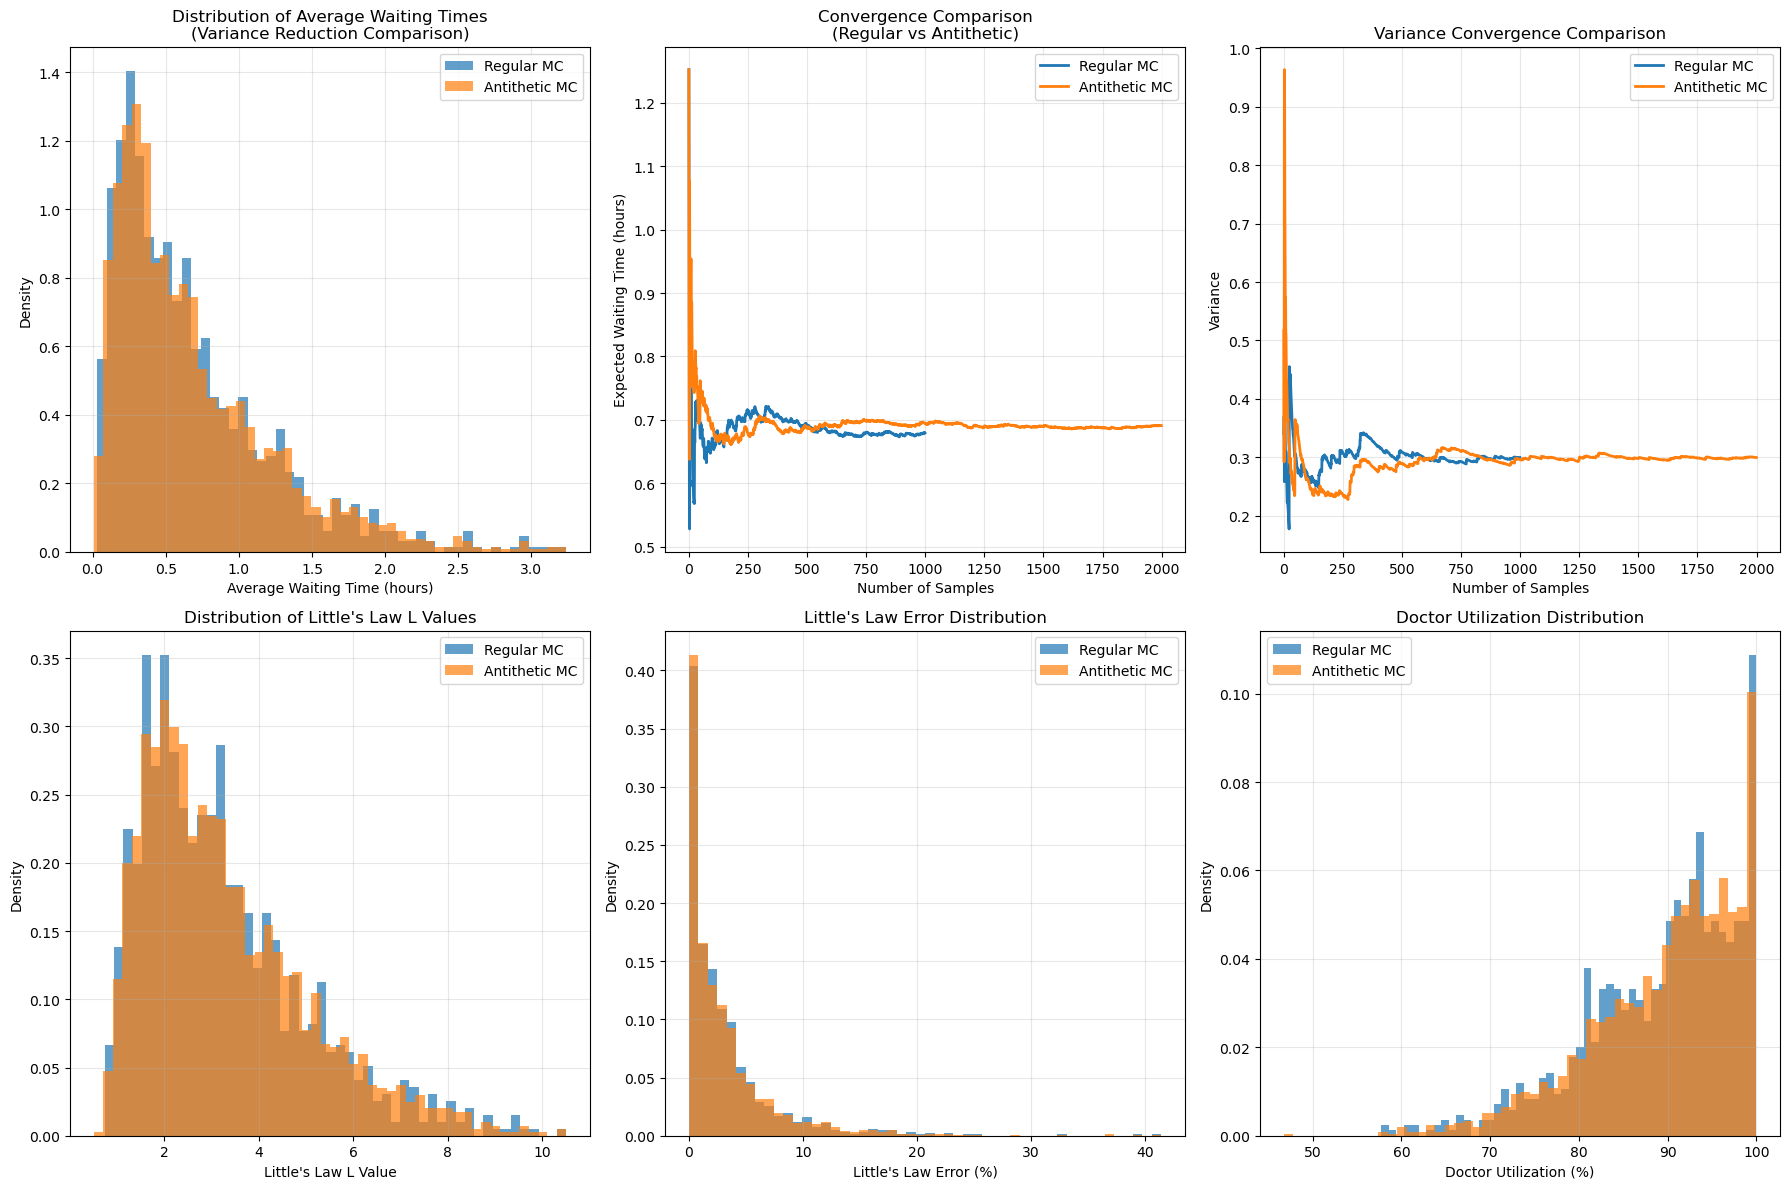


SAMPLE RESULTS SUMMARY (One Run with 40 Patients)

Patient Flow Details (Time in Hours):
 Customer_Sequence  Arrival_Time  Inter_Arrival_Time  Service_Start_Time  Service_End_Time  Waiting_Time
                 1      0.000000            0.199404            0.000000          0.117317      0.000000
                 2      0.199404            0.249517            0.199404          0.951934      0.000000
                 3      0.448921            0.176225            0.951934          1.281121      0.503014
                 4      0.625146            0.307414            1.281121          1.509357      0.655975
                 5      0.932560            0.221942            1.509357          1.551763      0.576797
                 6      1.154501            0.267844            1.551763          1.594162      0.397261
                 7      1.422346            0.228957            1.594162          1.609121      0.171816
                 8      1.651303            0.252027            1.6513

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

class ClinicQueueMonteCarlo:
    def __init__(self, clinic_hours=10, num_patients=40, mean_service_time=0.25, 
                 arrival_triangle_min=0.15, arrival_triangle_mode=0.25, arrival_triangle_max=0.35,
                 num_samples=1000):
        """
        Initialize the clinic queue Monte Carlo simulation
        
        Parameters:
        clinic_hours: Total clinic operating time in hours
        num_patients: Number of patients per day
        mean_service_time: Mean service time for exponential distribution (hours)
        arrival_triangle_min: Minimum inter-arrival time (hours)
        arrival_triangle_mode: Mode inter-arrival time (hours)
        arrival_triangle_max: Maximum inter-arrival time (hours)
        num_samples: Number of Monte Carlo samples
        """
        self.clinic_hours = clinic_hours
        self.num_patients = num_patients
        self.mean_service_time = mean_service_time
        self.arrival_triangle_min = arrival_triangle_min
        self.arrival_triangle_mode = arrival_triangle_mode
        self.arrival_triangle_max = arrival_triangle_max
        self.num_samples = num_samples
        self.results = None
    
    def calculate_empirical_customers_in_system(self, df):
        """
        Calculate empirical average number of customers in system (L_empirical)
        by analyzing the system state over time
        """
        # Create time points for analysis (every 0.01 hours ~ 36 seconds)
        time_points = np.arange(0, self.clinic_hours + 0.01, 0.01)
        customers_in_system = []
        
        for t in time_points:
            # Count customers who have arrived but not departed by time t
            arrived = df[df['Arrival_Time'] <= t]
            not_departed = arrived[arrived['Service_End_Time'] > t]
            num_in_system = len(not_departed)
            customers_in_system.append(num_in_system)
        
        # Calculate average number in system
        avg_customers_in_system = np.mean(customers_in_system)
        
        return {
            'time_points': time_points,
            'customers_in_system': customers_in_system,
            'avg_customers_in_system': avg_customers_in_system
        }
    
    def save_simulation_to_json(self, df, filename='basic_case_dataframe.json'):
        """Save simulation dataframe to JSON file"""
        # Convert DataFrame to JSON with proper formatting
        df.to_json(filename, orient='records', indent=2)
        print(f"\nSimulation data saved to {filename}")
    
    def simulate_single_run(self, service_times=None, inter_arrival_times=None, seed=None):
        """Simulate a single day of clinic operations"""
        if seed is not None:
            np.random.seed(seed)
        
        # Initialize arrays
        customer_sequence = []
        arrival_times = []
        service_start_times = []
        service_times_list = []
        service_end_times = []
        waiting_times = []
        time_in_system = []
        inter_arrival_list = []
        
        # Generate service times if not provided
        if service_times is None:
            service_times = np.random.exponential(self.mean_service_time, self.num_patients)
        
        # Generate inter-arrival times if not provided (triangular distribution)
        if inter_arrival_times is None:
            inter_arrival_times = np.random.triangular(
                self.arrival_triangle_min,
                self.arrival_triangle_mode,
                self.arrival_triangle_max,
                self.num_patients
            )
        
        # Process each patient
        cumulative_arrival_time = 0
        for i in range(self.num_patients):
            customer_sequence.append(i + 1)
            
            # Arrival time (cumulative sum of inter-arrival times)
            if i == 0:
                arrival_time = 0  # First patient arrives at time 0
            else:
                arrival_time = cumulative_arrival_time
            
            arrival_times.append(arrival_time)
            inter_arrival_list.append(inter_arrival_times[i] if i < len(inter_arrival_times) else 0)
            
            # Update cumulative arrival time for next patient
            if i < self.num_patients - 1:
                cumulative_arrival_time += inter_arrival_times[i]
            
            service_time = service_times[i]
            service_times_list.append(service_time)
            
            if i == 0:  # First patient
                service_start_time = arrival_time
                waiting_time = 0
            else:
                service_start_time = max(arrival_time, service_end_times[i-1])
                waiting_time = service_start_time - arrival_time
            
            service_start_times.append(service_start_time)
            waiting_times.append(waiting_time)
            
            service_end_time = service_start_time + service_time
            service_end_times.append(service_end_time)
            
            # Time in system (waiting + service)
            time_in_system.append(service_end_time - arrival_time)
        
        # Create DataFrame for this run
        df = pd.DataFrame({
            'Customer_Sequence': customer_sequence,
            'Arrival_Time': arrival_times,
            'Inter_Arrival_Time': inter_arrival_list,
            'Service_Start_Time': service_start_times,
            'Service_Time': service_times_list,
            'Service_End_Time': service_end_times,
            'Waiting_Time': waiting_times,
            'Time_in_System': time_in_system
        })
        
        return df
    
    def calculate_proper_littles_law(self, df, empirical_analysis=None):
        """Apply Little's Law correctly using system busy period"""
        
        # Use provided empirical analysis or calculate new one
        if empirical_analysis is None:
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
        
        # System starts empty at time 0
        start_time = 0
        
        # System ends when last patient departs
        end_time = df['Service_End_Time'].max()
        
        # Actual operating period for Little's Law
        operating_period = end_time - start_time
        
        # True arrival rate over the actual operating period
        true_λ = self.num_patients / operating_period
        
        # Average time in system
        W = df['Time_in_System'].mean()
        
        # Little's Law prediction
        L_little = true_λ * W
        
        # Empirical measurement over the same period
        mask = (empirical_analysis['time_points'] >= start_time) & (empirical_analysis['time_points'] <= end_time)
        L_empirical = np.mean(np.array(empirical_analysis['customers_in_system'])[mask])
        
        # Calculate difference and error
        difference = abs(L_little - L_empirical)
        relative_error = (difference / L_empirical) * 100 if L_empirical > 0 else 0
        
        result = {
            'arrival_rate': true_λ,
            'avg_time_in_system': W,
            'L_little': L_little,
            'L_empirical': L_empirical,
            'difference': difference,
            'relative_error_percent': relative_error,
            'operating_period': operating_period,
            'start_time': start_time,
            'end_time': end_time,
            'empirical_analysis': empirical_analysis
        }
        
        return result
    
    def triangular_inverse_transform(self, u, a, b, c):
        """
        Inverse transform for triangular distribution
        u: uniform random variable [0,1]
        a: minimum
        b: mode
        c: maximum
        """
        fc = (b - a) / (c - a)
        result = np.where(
            u < fc,
            a + np.sqrt(u * (c - a) * (b - a)),
            c - np.sqrt((1 - u) * (c - a) * (c - b))
        )
        return result
    
    def monte_carlo_regular(self):
        """Run regular Monte Carlo simulation without variance reduction"""
        print(f"Running {self.num_samples} regular Monte Carlo simulations...")
        
        regular_results = []
        littles_law_results = []
        all_run_data = []  # Store all individual run data
        
        for i in range(self.num_samples):
            df = self.simulate_single_run(seed=i)
            
            # Store individual run data
            run_data = df.copy()
            run_data['run_id'] = i
            all_run_data.append(run_data)
            
            # Empirical analysis of customers in system
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
            
            # Little's Law analysis
            littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
            littles_law_results.append(littles_result)
            
            avg_waiting_time = df['Waiting_Time'].mean()
            max_waiting_time = df['Waiting_Time'].max()
            total_service_time = df['Service_Time'].sum()
            last_departure = df['Service_End_Time'].iloc[-1]
            
            regular_results.append({
                'sample': i,
                'type': 'regular',
                'avg_waiting_time': avg_waiting_time,
                'max_waiting_time': max_waiting_time,
                'total_service_time': total_service_time,
                'last_departure': last_departure,
                'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                'L_little': littles_result['L_little'],
                'L_empirical': littles_result['L_empirical'],
                'littles_error_percent': littles_result['relative_error_percent']
            })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'basic_case_dataframe.json')
        
        return pd.DataFrame(regular_results), pd.DataFrame(littles_law_results)
    
    def monte_carlo_antithetic(self):
        """Run Monte Carlo simulation with antithetic variables for variance reduction"""
        print(f"Running {self.num_samples} Monte Carlo simulations with antithetic variables...")
        
        antithetic_results = []
        littles_law_results = []
        all_run_data = []  # Store all individual run data
        
        for i in range(self.num_samples):
            # Generate uniform random variables with seed i
            np.random.seed(i)
            
            # Uniform random variables for service times
            u_service = np.random.random(self.num_patients)
            # Uniform random variables for inter-arrival times
            u_arrival = np.random.random(self.num_patients)
            
            # First run: Use u
            service_times1 = -self.mean_service_time * np.log(1 - u_service)
            inter_arrival_times1 = self.triangular_inverse_transform(
                u_arrival, 
                self.arrival_triangle_min, 
                self.arrival_triangle_mode, 
                self.arrival_triangle_max
            )
            
            # Antithetic run: Use 1-u
            service_times2 = -self.mean_service_time * np.log(u_service)
            inter_arrival_times2 = self.triangular_inverse_transform(
                1 - u_arrival, 
                self.arrival_triangle_min, 
                self.arrival_triangle_mode, 
                self.arrival_triangle_max
            )
            
            # Run simulation with both sets
            for j, (service_times, inter_arrival_times) in enumerate([
                (service_times1, inter_arrival_times1), 
                (service_times2, inter_arrival_times2)
            ]):
                df = self.simulate_single_run(
                    service_times=service_times,
                    inter_arrival_times=inter_arrival_times
                )
                
                # Store individual run data
                run_data = df.copy()
                run_data['run_id'] = i * 2 + j
                run_data['pair_id'] = i
                all_run_data.append(run_data)
                
                # Empirical analysis of customers in system
                empirical_analysis = self.calculate_empirical_customers_in_system(df)
                
                # Little's Law analysis
                littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
                littles_law_results.append(littles_result)
                
                avg_waiting_time = df['Waiting_Time'].mean()
                max_waiting_time = df['Waiting_Time'].max()
                total_service_time = df['Service_Time'].sum()
                last_departure = df['Service_End_Time'].iloc[-1]
                
                antithetic_results.append({
                    'sample': i * 2 + j,
                    'type': 'antithetic',
                    'pair_id': i,
                    'avg_waiting_time': avg_waiting_time,
                    'max_waiting_time': max_waiting_time,
                    'total_service_time': total_service_time,
                    'last_departure': last_departure,
                    'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                    'L_little': littles_result['L_little'],
                    'L_empirical': littles_result['L_empirical'],
                    'littles_error_percent': littles_result['relative_error_percent']
                })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'antithetic_case_dataframe.json')
        
        return pd.DataFrame(antithetic_results), pd.DataFrame(littles_law_results)
    
    def run_both_methods(self):
        """Run both regular and antithetic Monte Carlo simulations"""
        print("Running both regular and antithetic Monte Carlo simulations...")
        
        # Regular Monte Carlo
        regular_df, regular_littles = self.monte_carlo_regular()
        
        # Antithetic Monte Carlo
        antithetic_df, antithetic_littles = self.monte_carlo_antithetic()
        
        self.results = {
            'regular': {
                'simulation': regular_df,
                'littles_law': regular_littles
            },
            'antithetic': {
                'simulation': antithetic_df,
                'littles_law': antithetic_littles
            }
        }
        
        return self.results
    
    def analyze_variance_reduction(self):
        """Analyze the effectiveness of antithetic variables for variance reduction"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        # Calculate statistics for waiting times
        regular_wait_var = regular_df['avg_waiting_time'].var()
        antithetic_wait_var = antithetic_df['avg_waiting_time'].var()
        
        # Calculate statistics for Little's Law L values
        regular_L_var = regular_df['L_little'].var()
        antithetic_L_var = antithetic_df['L_little'].var()
        
        # Variance reduction percentages
        wait_variance_reduction = (regular_wait_var - antithetic_wait_var) / regular_wait_var * 100
        L_variance_reduction = (regular_L_var - antithetic_L_var) / regular_L_var * 100
        
        print("\n" + "="*80)
        print("VARIANCE REDUCTION ANALYSIS (Antithetic Variables)")
        print("="*80)
        print(f"Average Waiting Time Analysis:")
        print(f"  Regular MC Variance: {regular_wait_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_wait_var:.6f}")
        print(f"  Variance Reduction: {wait_variance_reduction:.2f}%")
        
        print(f"\nLittle's Law L Analysis:")
        print(f"  Regular MC Variance: {regular_L_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_L_var:.6f}")
        print(f"  Variance Reduction: {L_variance_reduction:.2f}%")
        
        print(f"\nConfidence Interval Comparison:")
        regular_ci_width = 1.96 * np.sqrt(regular_wait_var / len(regular_df))
        antithetic_ci_width = 1.96 * np.sqrt(antithetic_wait_var / len(antithetic_df))
        print(f"  Regular MC CI Width: ±{regular_ci_width:.4f} hours")
        print(f"  Antithetic MC CI Width: ±{antithetic_ci_width:.4f} hours")
        print(f"  CI Width Reduction: {((regular_ci_width - antithetic_ci_width) / regular_ci_width * 100):.2f}%")
        
        return {
            'wait_variance_reduction': wait_variance_reduction,
            'L_variance_reduction': L_variance_reduction,
            'regular_stats': regular_df.describe(),
            'antithetic_stats': antithetic_df.describe()
        }
    
    def analyze_littles_law_validation(self):
        """Analyze Little's Law validation across both methods"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        # Little's Law validation statistics
        methods = ['regular', 'antithetic']
        results = {}
        
        for method in methods:
            df = self.results[method]['simulation']
            avg_L_little = df['L_little'].mean()
            avg_L_empirical = df['L_empirical'].mean()
            avg_error = df['littles_error_percent'].mean()
            
            # Statistical test for difference
            t_stat, p_value = stats.ttest_rel(df['L_little'], df['L_empirical'])
            
            results[method] = {
                'avg_L_little': avg_L_little,
                'avg_L_empirical': avg_L_empirical,
                'avg_error_percent': avg_error,
                'p_value': p_value
            }
        
        print("\n" + "="*80)
        print("LITTLE'S LAW VALIDATION COMPARISON")
        print("="*80)
        
        for method in methods:
            result = results[method]
            print(f"\n{method.upper()} Monte Carlo:")
            print(f"  L from Little's Law (λW): {result['avg_L_little']:.6f} customers")
            print(f"  L empirical (direct measurement): {result['avg_L_empirical']:.6f} customers")
            print(f"  Average relative error: {result['avg_error_percent']:.4f}%")
            print(f"  Paired t-test p-value: {result['p_value']:.6f}")
            if result['p_value'] > 0.05:
                print("  Conclusion: No significant difference (Little's Law holds)")
            else:
                print("  Conclusion: Significant difference detected")
        
        return results
    
    def plot_comparison(self):
        """Plot comparison between regular and antithetic methods"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Distribution of average waiting times
        axes[0, 0].hist(regular_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[0, 0].hist(antithetic_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[0, 0].set_xlabel('Average Waiting Time (hours)')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Distribution of Average Waiting Times\n(Variance Reduction Comparison)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Convergence of expected waiting time
        regular_cumulative = regular_df['avg_waiting_time'].expanding().mean()
        antithetic_cumulative = antithetic_df['avg_waiting_time'].expanding().mean()
        
        axes[0, 1].plot(regular_cumulative.index, regular_cumulative.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 1].plot(antithetic_cumulative.index, antithetic_cumulative.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 1].set_xlabel('Number of Samples')
        axes[0, 1].set_ylabel('Expected Waiting Time (hours)')
        axes[0, 1].set_title('Convergence Comparison\n(Regular vs Antithetic)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Variance comparison
        regular_variance = regular_df['avg_waiting_time'].expanding().var()
        antithetic_variance = antithetic_df['avg_waiting_time'].expanding().var()
        
        axes[0, 2].plot(regular_variance.index, regular_variance.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 2].plot(antithetic_variance.index, antithetic_variance.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 2].set_xlabel('Number of Samples')
        axes[0, 2].set_ylabel('Variance')
        axes[0, 2].set_title('Variance Convergence Comparison')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Little's Law L values distribution
        axes[1, 0].hist(regular_df['L_little'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 0].hist(antithetic_df['L_little'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 0].set_xlabel('Little\'s Law L Value')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Distribution of Little\'s Law L Values')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Error distribution comparison
        axes[1, 1].hist(regular_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 1].hist(antithetic_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 1].set_xlabel('Little\'s Law Error (%)')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Little\'s Law Error Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Doctor utilization comparison
        axes[1, 2].hist(regular_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 2].hist(antithetic_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 2].set_xlabel('Doctor Utilization (%)')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].set_title('Doctor Utilization Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize simulation
    mc_clinic = ClinicQueueMonteCarlo(
        clinic_hours=10,                # 10 hours
        num_patients=40,                # 40 patients
        mean_service_time=0.25,         # 0.25 hours (15 minutes) average service time
        arrival_triangle_min=0.15,      # Min inter-arrival time: 0.15 hours (9 minutes)
        arrival_triangle_mode=0.25,     # Mode inter-arrival time: 0.25 hours (15 minutes)
        arrival_triangle_max=0.35,      # Max inter-arrival time: 0.35 hours (21 minutes)
        num_samples=1000                # 1000 Monte Carlo samples
    )
    
    # Run both regular and antithetic Monte Carlo simulations
    results = mc_clinic.run_both_methods()
    
    # Analyze variance reduction
    variance_analysis = mc_clinic.analyze_variance_reduction()
    
    # Analyze Little's Law validation
    littles_analysis = mc_clinic.analyze_littles_law_validation()
    
    # Plot comprehensive comparison
    mc_clinic.plot_comparison()
    
    # Show sample results
    print("\n" + "="*80)
    print("SAMPLE RESULTS SUMMARY (One Run with 40 Patients)")
    print("="*80)
    
    sample_regular = mc_clinic.simulate_single_run(seed=42)
    empirical_analysis = mc_clinic.calculate_empirical_customers_in_system(sample_regular)
    littles_result = mc_clinic.calculate_proper_littles_law(sample_regular, empirical_analysis)
    
    print("\nPatient Flow Details (Time in Hours):")
    print(sample_regular[['Customer_Sequence', 'Arrival_Time', 'Inter_Arrival_Time',
                          'Service_Start_Time', 'Service_End_Time', 'Waiting_Time']].to_string(index=False))
    
    print(f"\n\nSummary Statistics:")
    print(f"  Average Inter-Arrival Time: {sample_regular['Inter_Arrival_Time'].mean():.4f} hours")
    print(f"  Average Waiting Time: {sample_regular['Waiting_Time'].mean():.4f} hours")
    print(f"  Maximum Waiting Time: {sample_regular['Waiting_Time'].max():.4f} hours")
    print(f"  Average Time in System: {sample_regular['Time_in_System'].mean():.4f} hours")
    print(f"  Total Service Time: {sample_regular['Service_Time'].sum():.4f} hours")
    print(f"  Last Patient Departure: {sample_regular['Service_End_Time'].iloc[-1]:.4f} hours")
    print(f"  Doctor Utilization: {(sample_regular['Service_Time'].sum() / sample_regular['Service_End_Time'].iloc[-1] * 100):.2f}%")

### Inspecting D/M/1 -- regular Monte Carlo

In [8]:
run_number = 0

single_run_basic_Tr_df = load_single_simulation_run(
    filename='basic_case_dataframe_Tr_M_1.json',
    run_id=run_number
)

print(f"\n{'='*60}")
print(f"Simulation Run #{run_number}")
print(f"{'='*60}")
print(f"\nNumber of customers in this run: {len(single_run_basic_Tr_df)}")
print(f"\n{single_run_basic_Tr_df}")

# Display summary statistics
print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"{'='*60}")
print(single_run_basic_Tr_df.describe())


Simulation Run #0

Number of customers in this run: 40

    Customer_Sequence  Arrival_Time  Inter_Arrival_Time  Service_Start_Time  \
0                   1      0.000000            0.234795            0.000000   
1                   2      0.234795            0.243491            0.234795   
2                   3      0.478286            0.272235            0.548777   
3                   4      0.750521            0.184706            0.779583   
4                   5      0.935227            0.268363            0.976384   
5                   6      1.203590            0.268838            1.203590   
6                   7      1.472428            0.214866            1.472428   
7                   8      1.687295            0.200779            1.687295   
8                   9      1.888074            0.229426            2.243176   
9                  10      2.117500            0.235289            3.071904   
10                 11      2.352789            0.257285            3.19280

### Inspecting Tr/M/1 -- antithetic Monte Carlo 

In [7]:
run_number = 0

single_run_antithetic_Tr_df = load_single_simulation_run(
    filename='antithetic_case_dataframe_Tr_M_1.json',
    run_id=run_number
)

print(f"\n{'='*60}")
print(f"Simulation Run #{run_number}")
print(f"{'='*60}")
print(f"\nNumber of customers in this run: {len(single_run_antithetic_Tr_df)}")
print(f"\n{single_run_antithetic_Tr_df}")

# Display summary statistics
print(f"\n{'='*60}")
print("Summary Statistics:")
print(f"{'='*60}")
print(single_run_antithetic_Tr_df.describe())


Simulation Run #0

Number of customers in this run: 40

    Customer_Sequence  Arrival_Time  Inter_Arrival_Time  Service_Start_Time  \
0                   1      0.000000            0.234795            0.000000   
1                   2      0.234795            0.243491            0.234795   
2                   3      0.478286            0.272235            0.548777   
3                   4      0.750521            0.184706            0.779583   
4                   5      0.935227            0.268363            0.976384   
5                   6      1.203590            0.268838            1.203590   
6                   7      1.472428            0.214866            1.472428   
7                   8      1.687295            0.200779            1.687295   
8                   9      1.888074            0.229426            2.243176   
9                  10      2.117500            0.235289            3.071904   
10                 11      2.352789            0.257285            3.19280

Normal Distribution for Unpunctuality

Running both regular and antithetic Monte Carlo simulations with unpunctuality...
Running 1000 regular Monte Carlo simulations with unpunctuality...

Simulation data saved to unpunctuality_regular_dataframe.json
Running 1000 Monte Carlo simulations with antithetic variables and unpunctuality...

Simulation data saved to unpunctuality_antithetic_dataframe.json

VARIANCE REDUCTION ANALYSIS (Antithetic Variables with Unpunctuality)
Average Waiting Time Analysis:
  Regular MC Variance: 0.292781
  Antithetic MC Variance: 0.302225
  Variance Reduction: -3.23%

Little's Law L Analysis:
  Regular MC Variance: 2.929450
  Antithetic MC Variance: 2.994384
  Variance Reduction: -2.22%

Confidence Interval Comparison:
  Regular MC CI Width: ±0.0335 hours
  Antithetic MC CI Width: ±0.0241 hours
  CI Width Reduction: 28.16%

Unpunctuality Analysis:
  Regular MC - Avg Unpunctuality: -0.00 minutes
  Regular MC - Avg % Early: 50.14%
  Regular MC - Avg % Late: 49.86%
  Antithetic MC - Avg Unpunctuality: 

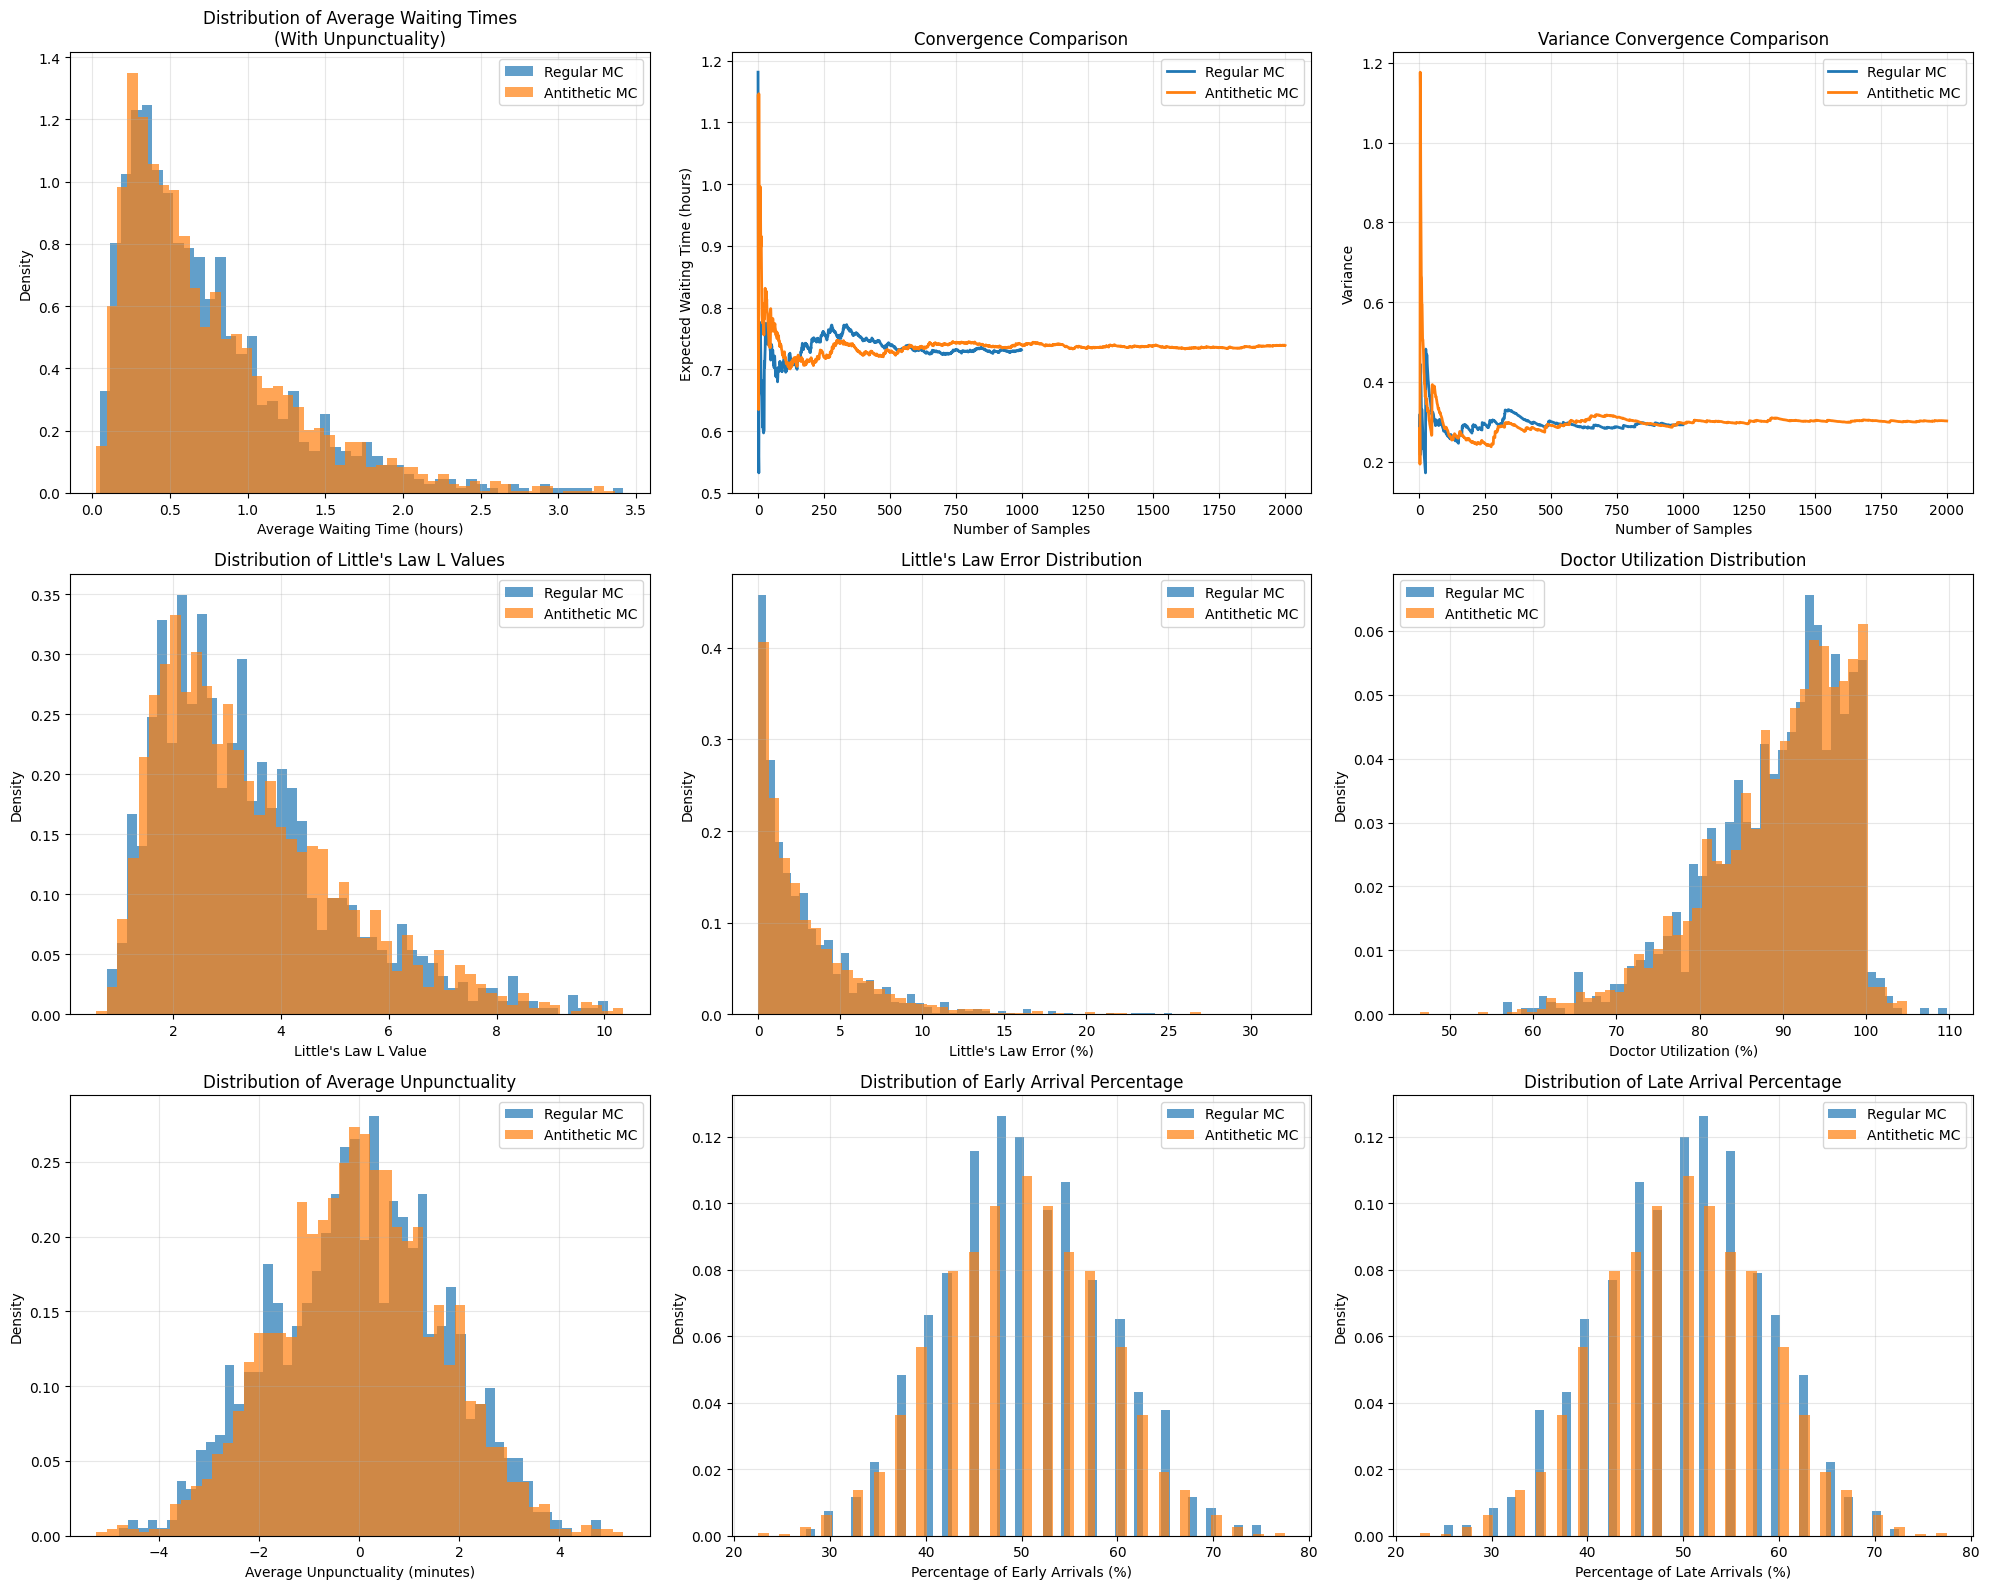


SAMPLE RESULTS WITH UNPUNCTUALITY (One Run with 40 Patients)

Patient Flow Details (Time in Hours):
 Customer_ID  Scheduled_Appointment  Unpunctuality  Actual_Arrival_Time  Service_Start_Time  Service_End_Time  Waiting_Time
           1                   0.00       0.082786             0.082786            0.082786          0.200103      0.000000
           2                   0.25      -0.023044             0.226956            0.226956          0.979486      0.000000
           3                   0.50       0.107948             0.607948            0.979486          1.308673      0.371538
           4                   0.75       0.253838             1.003838            1.351079          1.579315      0.347241
           5                   1.00      -0.039026             0.960974            1.308673          1.351079      0.347698
           6                   1.25      -0.039023             1.210977            1.579315          1.621714      0.368337
           7                   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

class ClinicQueueMonteCarlo:
    def __init__(self, clinic_hours=10, num_patients=40, mean_service_time=0.25, 
                 num_samples=1000, appointment_interval=0.25, 
                 unpunctuality_mean=0, unpunctuality_std=10/60,
                 unpunctuality_bounds=(-30/60, 60/60)):
        """
        Initialize the clinic queue Monte Carlo simulation with patient unpunctuality
        
        Parameters:
        clinic_hours: Total clinic operating time in hours
        num_patients: Number of patients per day
        mean_service_time: Mean service time for exponential distribution (hours)
        num_samples: Number of Monte Carlo samples
        appointment_interval: Fixed interval between appointments (hours) - default 0.25 (15 min)
        unpunctuality_mean: Mean of unpunctuality distribution (hours) - default 0
        unpunctuality_std: Std dev of unpunctuality distribution (hours) - default 10/60 (10 min)
        unpunctuality_bounds: Tuple of (lower, upper) bounds for truncation (hours) - default (-30min, +60min)
        """
        self.clinic_hours = clinic_hours
        self.num_patients = num_patients
        self.mean_service_time = mean_service_time
        self.num_samples = num_samples
        self.appointment_interval = appointment_interval  # Fixed appointment interval
        self.unpunctuality_mean = unpunctuality_mean
        self.unpunctuality_std = unpunctuality_std
        self.unpunctuality_bounds = unpunctuality_bounds
        self.results = None
    
    def generate_unpunctuality(self, size, seed=None):
        """
        Generate patient unpunctuality following truncated normal distribution
        Based on: U(c) ~ N(μU, σU) truncated to reasonable bounds
        
        Returns unpunctuality in hours
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Generate from normal distribution
        unpunctuality_raw = np.random.normal(
            self.unpunctuality_mean, 
            self.unpunctuality_std, 
            size
        )
        
        # Truncate to bounds
        unpunctuality = np.clip(
            unpunctuality_raw,
            self.unpunctuality_bounds[0],
            self.unpunctuality_bounds[1]
        )
        
        return unpunctuality
    
    def calculate_empirical_customers_in_system(self, df):
        """
        Calculate empirical average number of customers in system (L_empirical)
        by analyzing the system state over time
        """
        # Create time points for analysis (every minute)
        time_step = 1/60  # 1 minute in hours
        time_points = np.arange(0, self.clinic_hours + time_step, time_step)
        customers_in_system = []
        
        for t in time_points:
            # Count customers who have arrived but not departed by time t
            arrived = df[df['Actual_Arrival_Time'] <= t]
            not_departed = arrived[arrived['Service_End_Time'] > t]
            num_in_system = len(not_departed)
            customers_in_system.append(num_in_system)
        
        # Calculate average number in system
        avg_customers_in_system = np.mean(customers_in_system)
        
        return {
            'time_points': time_points,
            'customers_in_system': customers_in_system,
            'avg_customers_in_system': avg_customers_in_system
        }
        
    def save_simulation_to_json(self, df, filename='simulation_dataframe.json'):
        """Save simulation dataframe to JSON file"""
        df.to_json(filename, orient='records', indent=2)
        print(f"\nSimulation data saved to {filename}")
    
    def simulate_single_run(self, service_times=None, unpunctuality=None, seed=None):
        """
        Simulate a single day of clinic operations with scheduled appointments and unpunctuality
        
        Returns DataFrame with both scheduled and actual arrival information
        """
        if seed is not None:
            np.random.seed(seed)
        
        # Generate service times if not provided
        if service_times is None:
            service_times = np.random.exponential(self.mean_service_time, self.num_patients)
        
        # Generate scheduled appointment times (fixed intervals)
        scheduled_appointment_times = [i * self.appointment_interval for i in range(self.num_patients)]
        
        # Generate unpunctuality if not provided
        if unpunctuality is None:
            unpunctuality = self.generate_unpunctuality(self.num_patients, seed=seed)
        
        # Calculate actual arrival times
        actual_arrival_times = [
            scheduled_appointment_times[i] + unpunctuality[i] 
            for i in range(self.num_patients)
        ]
        
        # Sort patients by actual arrival time (they may arrive out of appointment order!)
        arrival_order = np.argsort(actual_arrival_times)
        
        # Process each patient IN ARRIVAL ORDER
        results = []
        last_service_end = 0
        
        for idx in arrival_order:
            customer_id = idx + 1
            scheduled_time = scheduled_appointment_times[idx]
            unpunctual_amount = unpunctuality[idx]
            arrival_time = actual_arrival_times[idx]
            service_time = service_times[idx]
            
            # Service starts when both patient has arrived AND doctor is free
            service_start_time = max(arrival_time, last_service_end)
            
            # Waiting time (from arrival to service start)
            waiting_time = service_start_time - arrival_time
            
            # Service end time
            service_end_time = service_start_time + service_time
            
            # Update last service end for next patient
            last_service_end = service_end_time
            
            # Time in system
            time_in_sys = service_end_time - arrival_time
            
            results.append({
                'Customer_ID': customer_id,
                'Scheduled_Appointment': scheduled_time,
                'Unpunctuality': unpunctual_amount,
                'Actual_Arrival_Time': arrival_time,
                'Service_Start_Time': service_start_time,
                'Service_Time': service_time,
                'Service_End_Time': service_end_time,
                'Waiting_Time': waiting_time,
                'Time_in_System': time_in_sys,
                'Arrived_Early': unpunctual_amount < 0,
                'Arrived_Late': unpunctual_amount > 0
            })
        
        # Create DataFrame sorted by customer ID (original appointment order)
        df = pd.DataFrame(results)
        df = df.sort_values('Customer_ID').reset_index(drop=True)
        
        return df
    
    def calculate_proper_littles_law(self, df, empirical_analysis=None):
        """Apply Little's Law correctly using system busy period"""
        
        # Use provided empirical analysis or calculate new one
        if empirical_analysis is None:
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
        
        # System starts empty at time 0
        start_time = 0
        
        # System ends when last patient departs
        end_time = df['Service_End_Time'].max()
        
        # Actual operating period for Little's Law
        operating_period = end_time - start_time
        
        # True arrival rate over the actual operating period
        true_λ = self.num_patients / operating_period
        
        # Average time in system
        W = df['Time_in_System'].mean()
        
        # Little's Law prediction
        L_little = true_λ * W
        
        # Empirical measurement over the same period
        mask = (empirical_analysis['time_points'] >= start_time) & (empirical_analysis['time_points'] <= end_time)
        L_empirical = np.mean(np.array(empirical_analysis['customers_in_system'])[mask])
        
        # Calculate difference and error
        difference = abs(L_little - L_empirical)
        relative_error = (difference / L_empirical) * 100 if L_empirical > 0 else 0
        
        result = {
            'arrival_rate': true_λ,
            'avg_time_in_system': W,
            'L_little': L_little,
            'L_empirical': L_empirical,
            'difference': difference,
            'relative_error_percent': relative_error,
            'operating_period': operating_period,
            'start_time': start_time,
            'end_time': end_time,
            'empirical_analysis': empirical_analysis
        }
        
        return result
    
    def monte_carlo_regular(self):
        """Run regular Monte Carlo simulation without variance reduction"""
        print(f"Running {self.num_samples} regular Monte Carlo simulations with unpunctuality...")
        
        regular_results = []
        littles_law_results = []
        all_run_data = []
        
        for i in range(self.num_samples):
            df = self.simulate_single_run(seed=i)
            
            # Store individual run data
            run_data = df.copy()
            run_data['run_id'] = i
            all_run_data.append(run_data)
            
            # Empirical analysis
            empirical_analysis = self.calculate_empirical_customers_in_system(df)
            
            # Little's Law analysis
            littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
            littles_law_results.append(littles_result)
            
            # Calculate metrics
            avg_waiting_time = df['Waiting_Time'].mean()
            max_waiting_time = df['Waiting_Time'].max()
            total_service_time = df['Service_Time'].sum()
            last_departure = df['Service_End_Time'].iloc[-1]
            avg_unpunctuality = df['Unpunctuality'].mean()
            std_unpunctuality = df['Unpunctuality'].std()
            pct_early = (df['Arrived_Early'].sum() / len(df)) * 100
            pct_late = (df['Arrived_Late'].sum() / len(df)) * 100
            
            regular_results.append({
                'sample': i,
                'type': 'regular',
                'avg_waiting_time': avg_waiting_time,
                'max_waiting_time': max_waiting_time,
                'total_service_time': total_service_time,
                'last_departure': last_departure,
                'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                'L_little': littles_result['L_little'],
                'L_empirical': littles_result['L_empirical'],
                'littles_error_percent': littles_result['relative_error_percent'],
                'avg_unpunctuality': avg_unpunctuality,
                'std_unpunctuality': std_unpunctuality,
                'pct_early': pct_early,
                'pct_late': pct_late
            })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'unpunctuality_regular_dataframe.json')
        
        return pd.DataFrame(regular_results), pd.DataFrame(littles_law_results)
    
    def monte_carlo_antithetic(self):
        """Run Monte Carlo simulation with antithetic variables for variance reduction"""
        print(f"Running {self.num_samples} Monte Carlo simulations with antithetic variables and unpunctuality...")
        
        antithetic_results = []
        littles_law_results = []
        all_run_data = []
        
        for i in range(self.num_samples):
            # First run with seed i
            np.random.seed(i)
            
            # Generate service times (antithetic pair)
            u1 = np.random.random(self.num_patients)
            service_times1 = -self.mean_service_time * np.log(1 - u1)
            service_times2 = -self.mean_service_time * np.log(u1)
            
            # Generate unpunctuality (antithetic pair)
            u2 = np.random.random(self.num_patients)
            # Use inverse CDF of normal distribution
            from scipy.stats import norm
            unpunctuality1 = norm.ppf(u2, self.unpunctuality_mean, self.unpunctuality_std)
            unpunctuality2 = norm.ppf(1 - u2, self.unpunctuality_mean, self.unpunctuality_std)
            
            # Truncate both
            unpunctuality1 = np.clip(unpunctuality1, *self.unpunctuality_bounds)
            unpunctuality2 = np.clip(unpunctuality2, *self.unpunctuality_bounds)
            
            # Run simulation with both sets
            for j, (service_times, unpunctuality) in enumerate([
                (service_times1, unpunctuality1), 
                (service_times2, unpunctuality2)
            ]):
                df = self.simulate_single_run(service_times=service_times, unpunctuality=unpunctuality)
                
                # Store individual run data
                run_data = df.copy()
                run_data['run_id'] = i * 2 + j
                run_data['pair_id'] = i
                all_run_data.append(run_data)
                
                # Empirical analysis
                empirical_analysis = self.calculate_empirical_customers_in_system(df)
                
                # Little's Law analysis
                littles_result = self.calculate_proper_littles_law(df, empirical_analysis)
                littles_law_results.append(littles_result)
                
                # Calculate metrics
                avg_waiting_time = df['Waiting_Time'].mean()
                max_waiting_time = df['Waiting_Time'].max()
                total_service_time = df['Service_Time'].sum()
                last_departure = df['Service_End_Time'].iloc[-1]
                avg_unpunctuality = df['Unpunctuality'].mean()
                std_unpunctuality = df['Unpunctuality'].std()
                pct_early = (df['Arrived_Early'].sum() / len(df)) * 100
                pct_late = (df['Arrived_Late'].sum() / len(df)) * 100
                
                antithetic_results.append({
                    'sample': i * 2 + j,
                    'type': 'antithetic',
                    'pair_id': i,
                    'avg_waiting_time': avg_waiting_time,
                    'max_waiting_time': max_waiting_time,
                    'total_service_time': total_service_time,
                    'last_departure': last_departure,
                    'doctor_utilization': (total_service_time / last_departure) * 100 if last_departure > 0 else 0,
                    'L_little': littles_result['L_little'],
                    'L_empirical': littles_result['L_empirical'],
                    'littles_error_percent': littles_result['relative_error_percent'],
                    'avg_unpunctuality': avg_unpunctuality,
                    'std_unpunctuality': std_unpunctuality,
                    'pct_early': pct_early,
                    'pct_late': pct_late
                })
        
        # Save all individual runs to JSON
        all_runs_df = pd.concat(all_run_data, ignore_index=True)
        self.save_simulation_to_json(all_runs_df, 'unpunctuality_antithetic_dataframe.json')
        
        return pd.DataFrame(antithetic_results), pd.DataFrame(littles_law_results)
    
    def run_both_methods(self):
        """Run both regular and antithetic Monte Carlo simulations"""
        print("Running both regular and antithetic Monte Carlo simulations with unpunctuality...")
        
        # Regular Monte Carlo
        regular_df, regular_littles = self.monte_carlo_regular()
        
        # Antithetic Monte Carlo
        antithetic_df, antithetic_littles = self.monte_carlo_antithetic()
        
        self.results = {
            'regular': {
                'simulation': regular_df,
                'littles_law': regular_littles
            },
            'antithetic': {
                'simulation': antithetic_df,
                'littles_law': antithetic_littles
            }
        }
        
        return self.results
    
    def analyze_variance_reduction(self):
        """Analyze the effectiveness of antithetic variables for variance reduction"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        # Calculate statistics for waiting times
        regular_wait_var = regular_df['avg_waiting_time'].var()
        antithetic_wait_var = antithetic_df['avg_waiting_time'].var()
        
        # Calculate statistics for Little's Law L values
        regular_L_var = regular_df['L_little'].var()
        antithetic_L_var = antithetic_df['L_little'].var()
        
        # Variance reduction percentages
        wait_variance_reduction = (regular_wait_var - antithetic_wait_var) / regular_wait_var * 100
        L_variance_reduction = (regular_L_var - antithetic_L_var) / regular_L_var * 100
        
        print("\n" + "="*80)
        print("VARIANCE REDUCTION ANALYSIS (Antithetic Variables with Unpunctuality)")
        print("="*80)
        print(f"Average Waiting Time Analysis:")
        print(f"  Regular MC Variance: {regular_wait_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_wait_var:.6f}")
        print(f"  Variance Reduction: {wait_variance_reduction:.2f}%")
        
        print(f"\nLittle's Law L Analysis:")
        print(f"  Regular MC Variance: {regular_L_var:.6f}")
        print(f"  Antithetic MC Variance: {antithetic_L_var:.6f}")
        print(f"  Variance Reduction: {L_variance_reduction:.2f}%")
        
        print(f"\nConfidence Interval Comparison:")
        regular_ci_width = 1.96 * np.sqrt(regular_wait_var / len(regular_df))
        antithetic_ci_width = 1.96 * np.sqrt(antithetic_wait_var / len(antithetic_df))
        print(f"  Regular MC CI Width: ±{regular_ci_width:.4f} hours")
        print(f"  Antithetic MC CI Width: ±{antithetic_ci_width:.4f} hours")
        print(f"  CI Width Reduction: {((regular_ci_width - antithetic_ci_width) / regular_ci_width * 100):.2f}%")
        
        # Unpunctuality statistics
        print(f"\nUnpunctuality Analysis:")
        print(f"  Regular MC - Avg Unpunctuality: {regular_df['avg_unpunctuality'].mean()*60:.2f} minutes")
        print(f"  Regular MC - Avg % Early: {regular_df['pct_early'].mean():.2f}%")
        print(f"  Regular MC - Avg % Late: {regular_df['pct_late'].mean():.2f}%")
        print(f"  Antithetic MC - Avg Unpunctuality: {antithetic_df['avg_unpunctuality'].mean()*60:.2f} minutes")
        print(f"  Antithetic MC - Avg % Early: {antithetic_df['pct_early'].mean():.2f}%")
        print(f"  Antithetic MC - Avg % Late: {antithetic_df['pct_late'].mean():.2f}%")
        
        return {
            'wait_variance_reduction': wait_variance_reduction,
            'L_variance_reduction': L_variance_reduction,
            'regular_stats': regular_df.describe(),
            'antithetic_stats': antithetic_df.describe()
        }
    
    def analyze_littles_law_validation(self):
        """Analyze Little's Law validation across both methods"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        methods = ['regular', 'antithetic']
        results = {}
        
        for method in methods:
            df = self.results[method]['simulation']
            avg_L_little = df['L_little'].mean()
            avg_L_empirical = df['L_empirical'].mean()
            avg_error = df['littles_error_percent'].mean()
            
            # Statistical test for difference
            t_stat, p_value = stats.ttest_rel(df['L_little'], df['L_empirical'])
            
            results[method] = {
                'avg_L_little': avg_L_little,
                'avg_L_empirical': avg_L_empirical,
                'avg_error_percent': avg_error,
                'p_value': p_value
            }
        
        print("\n" + "="*80)
        print("LITTLE'S LAW VALIDATION COMPARISON (With Unpunctuality)")
        print("="*80)
        
        for method in methods:
            result = results[method]
            print(f"\n{method.upper()} Monte Carlo:")
            print(f"  L from Little's Law (λW): {result['avg_L_little']:.6f} customers")
            print(f"  L empirical (direct measurement): {result['avg_L_empirical']:.6f} customers")
            print(f"  Average relative error: {result['avg_error_percent']:.4f}%")
            print(f"  Paired t-test p-value: {result['p_value']:.6f}")
            if result['p_value'] > 0.05:
                print("  Conclusion: No significant difference (Little's Law holds)")
            else:
                print("  Conclusion: Significant difference detected")
        
        return results
    
    def plot_comparison(self):
        """Plot comparison between regular and antithetic methods with unpunctuality analysis"""
        if self.results is None:
            print("Please run run_both_methods() first.")
            return
        
        regular_df = self.results['regular']['simulation']
        antithetic_df = self.results['antithetic']['simulation']
        
        fig, axes = plt.subplots(3, 3, figsize=(20, 16))
        
        # Plot 1: Distribution of average waiting times
        axes[0, 0].hist(regular_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[0, 0].hist(antithetic_df['avg_waiting_time'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[0, 0].set_xlabel('Average Waiting Time (hours)')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].set_title('Distribution of Average Waiting Times\n(With Unpunctuality)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Convergence of expected waiting time
        regular_cumulative = regular_df['avg_waiting_time'].expanding().mean()
        antithetic_cumulative = antithetic_df['avg_waiting_time'].expanding().mean()
        
        axes[0, 1].plot(regular_cumulative.index, regular_cumulative.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 1].plot(antithetic_cumulative.index, antithetic_cumulative.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 1].set_xlabel('Number of Samples')
        axes[0, 1].set_ylabel('Expected Waiting Time (hours)')
        axes[0, 1].set_title('Convergence Comparison')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Variance comparison
        regular_variance = regular_df['avg_waiting_time'].expanding().var()
        antithetic_variance = antithetic_df['avg_waiting_time'].expanding().var()
        
        axes[0, 2].plot(regular_variance.index, regular_variance.values, 
                       label='Regular MC', linewidth=2)
        axes[0, 2].plot(antithetic_variance.index, antithetic_variance.values, 
                       label='Antithetic MC', linewidth=2)
        axes[0, 2].set_xlabel('Number of Samples')
        axes[0, 2].set_ylabel('Variance')
        axes[0, 2].set_title('Variance Convergence Comparison')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Little's Law L values distribution
        axes[1, 0].hist(regular_df['L_little'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 0].hist(antithetic_df['L_little'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 0].set_xlabel('Little\'s Law L Value')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Distribution of Little\'s Law L Values')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Error distribution comparison
        axes[1, 1].hist(regular_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 1].hist(antithetic_df['littles_error_percent'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 1].set_xlabel('Little\'s Law Error (%)')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Little\'s Law Error Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Plot 6: Doctor utilization comparison
        axes[1, 2].hist(regular_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[1, 2].hist(antithetic_df['doctor_utilization'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[1, 2].set_xlabel('Doctor Utilization (%)')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].set_title('Doctor Utilization Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        # Plot 7: Unpunctuality distribution (convert to minutes)
        axes[2, 0].hist(regular_df['avg_unpunctuality']*60, bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[2, 0].hist(antithetic_df['avg_unpunctuality']*60, bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[2, 0].set_xlabel('Average Unpunctuality (minutes)')
        axes[2, 0].set_ylabel('Density')
        axes[2, 0].set_title('Distribution of Average Unpunctuality')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Plot 8: Percentage of early arrivals
        axes[2, 1].hist(regular_df['pct_early'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[2, 1].hist(antithetic_df['pct_early'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[2, 1].set_xlabel('Percentage of Early Arrivals (%)')
        axes[2, 1].set_ylabel('Density')
        axes[2, 1].set_title('Distribution of Early Arrival Percentage')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        # Plot 9: Percentage of late arrivals
        axes[2, 2].hist(regular_df['pct_late'], bins=50, alpha=0.7, 
                       label='Regular MC', density=True)
        axes[2, 2].hist(antithetic_df['pct_late'], bins=50, alpha=0.7, 
                       label='Antithetic MC', density=True)
        axes[2, 2].set_xlabel('Percentage of Late Arrivals (%)')
        axes[2, 2].set_ylabel('Density')
        axes[2, 2].set_title('Distribution of Late Arrival Percentage')
        axes[2, 2].legend()
        axes[2, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('unpunctuality_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize simulation with unpunctuality parameters
    # Using parameters from the literature: μU = 0, σU = 10 minutes
    mc_clinic = ClinicQueueMonteCarlo(
        clinic_hours=10,              # 10 hours
        num_patients=40,              # 40 patients
        mean_service_time=0.25,       # 0.25 hours (15 minutes) average service time
        num_samples=1000,             # 1000 Monte Carlo samples
        appointment_interval=0.25,    # 15-minute fixed intervals
        unpunctuality_mean=0,         # Mean = 0 minutes (centered)
        unpunctuality_std=10/60,      # Std = 10 minutes converted to hours
        unpunctuality_bounds=(-30/60, 60/60)  # Truncate: -30min to +60min
    )
    
    # Run both regular and antithetic Monte Carlo simulations
    results = mc_clinic.run_both_methods()
    
    # Analyze variance reduction
    variance_analysis = mc_clinic.analyze_variance_reduction()
    
    # Analyze Little's Law validation
    littles_analysis = mc_clinic.analyze_littles_law_validation()
    
    # Plot comprehensive comparison
    mc_clinic.plot_comparison()
    
    # Show sample results with unpunctuality details
    print("\n" + "="*80)
    print("SAMPLE RESULTS WITH UNPUNCTUALITY (One Run with 40 Patients)")
    print("="*80)
    
    sample_run = mc_clinic.simulate_single_run(seed=42)
    empirical_analysis = mc_clinic.calculate_empirical_customers_in_system(sample_run)
    littles_result = mc_clinic.calculate_proper_littles_law(sample_run, empirical_analysis)
    
    print("\nPatient Flow Details (Time in Hours):")
    print(sample_run[['Customer_ID', 'Scheduled_Appointment', 'Unpunctuality', 
                      'Actual_Arrival_Time', 'Service_Start_Time', 
                      'Service_End_Time', 'Waiting_Time']].to_string(index=False))
    
    print(f"\n\nSummary Statistics:")
    print(f"  Average Waiting Time: {sample_run['Waiting_Time'].mean():.4f} hours ({sample_run['Waiting_Time'].mean()*60:.2f} minutes)")
    print(f"  Maximum Waiting Time: {sample_run['Waiting_Time'].max():.4f} hours ({sample_run['Waiting_Time'].max()*60:.2f} minutes)")
    print(f"  Average Time in System: {sample_run['Time_in_System'].mean():.4f} hours")
    print(f"  Average Unpunctuality: {sample_run['Unpunctuality'].mean()*60:.2f} minutes")
    print(f"  Std Dev Unpunctuality: {sample_run['Unpunctuality'].std()*60:.2f} minutes")
    print(f"  Patients Arriving Early: {sample_run['Arrived_Early'].sum()} ({(sample_run['Arrived_Early'].sum()/len(sample_run)*100):.1f}%)")
    print(f"  Patients Arriving Late: {sample_run['Arrived_Late'].sum()} ({(sample_run['Arrived_Late'].sum()/len(sample_run)*100):.1f}%)")
    print(f"  Total Service Time: {sample_run['Service_Time'].sum():.4f} hours")
    print(f"  Last Patient Departure: {sample_run['Service_End_Time'].iloc[-1]:.4f} hours")
    print(f"  Doctor Utilization: {(sample_run['Service_Time'].sum() / sample_run['Service_End_Time'].iloc[-1] * 100):.2f}%")
    
    print("\n" + "="*80)
    print("To test different unpunctuality scenarios, modify:")
    print("  - unpunctuality_std: Try 20/60 for higher variability (σ=20 min)")
    print("  - unpunctuality_bounds: Adjust truncation limits")
    print("  - unpunctuality_mean: Add systematic early/late bias")
    print("="*80)